## Common Utilities (Run it first)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
import re
from gensim.models import TfidfModel
from scipy import stats
from gensim.corpora import Dictionary
from textblob import TextBlob
from autocorrect import Speller
from spellchecker import SpellChecker
from collections import Counter, defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from empath import Empath
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
warnings.filterwarnings('ignore')

# CONFIGURATION & CONSTANTS

# Category definitions
CATEGORIES = ['hate_speech', 'offensive_language', 'neither']

# Mapping: class number → category name
CLASS_TO_CATEGORY = {
    0: 'hate_speech',
    1: 'offensive_language',
    2: 'neither'
}

# Mapping: category name → class number  
CATEGORY_TO_CLASS = {
    'hate_speech': 0,
    'offensive_language': 1,
    'neither': 2
}

# Analysis parameters (eliminates magic numbers)
TOP_N_FREQUENT_WORDS = 30
TOP_N_TFIDF_WORDS = 30
TOP_N_EMPATH_CATEGORIES = 15
N_ERROR_EXAMPLES = 20
N_SENTIMENT_BINS = 10
CONFIDENCE_LEVEL = 0.90
HEAPS_LAW_STEP_SIZE = 50

# Pronoun POS tags (Penn Treebank)
PRONOUN_TAGS = ['PRP', 'PRP$']

### Helper Functions

In [58]:
# UTILITY FUNCTIONS (Defined once, used throughout)

def download_nltk_data():
    """Download necessary NLTK resources."""
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('wordnet', quiet=True)
    return set(stopwords.words('english'))

def clean_text(text):
    """
    Clean and normalize text for analysis.
    
    Removes HTML entities, URLs, mentions, hashtags, RT indicators,
    and normalizes whitespace.
    """
    if pd.isna(text):
        return ""
    
    text = str(text).lower()

    # Remove HTML entities
    text = re.sub(r'&amp;?', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    text = re.sub(r'&#\d+;', '', text)

    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    # text = re.sub(r'#\w+', '', text)

    # Remove RT (retweet) indicator
    text = re.sub(r'\brt\b', '', text, flags=re.IGNORECASE)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def tokenize_text(text):
    """
    Tokenize text into alphabetic words.
    
    Returns list of lowercase alphabetic tokens with length > 1.
    """
    tokens = word_tokenize(text)
    # Keep only alphabetic tokens (remove punctuation, numbers, emoji)
    tokens = [token for token in tokens if token.isalpha() and len(token) > 1]

    return tokens

def remove_stopwords(tokens, stopword_set):
    """Remove stopwords from token list."""
    return [token for token in tokens if token not in stopword_set]

def count_pronouns(tokens):
    """
    Count pronouns using POS tagging.
    
    Counts personal pronouns (PRP) and possessive pronouns (PRP$).
    """
    if not tokens:
        return 0
    pos_tags = nltk.pos_tag(tokens)
    pronoun_count = sum(1 for word, tag in pos_tags if tag in PRONOUN_TAGS)
    return pronoun_count

def is_valid_word(word):
    """
    Check if word exists in WordNet lexicon.
    
    Returns True if word is valid (in WordNet or is a number).
    """
    if not word or word.isdigit():
        return True
    word_lower = word.lower()
    return len(wordnet.synsets(word_lower)) > 0

def get_category_dataframe(df, category_name):
    """
    Filter dataframe by category name.
    
    Returns dataframe filtered to specified category.
    """
    class_num = CATEGORY_TO_CLASS[category_name]
    return df[df['class'] == class_num]

def load_and_explore_data(filepath):
    """Load data and print exploration statistics."""
    print("--- Data Loading and Exploration ---")
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nClass distribution:\n{df['class'].value_counts()}")
    return df

def preprocess_data(df, stopword_set):
    """
    Apply all preprocessing steps to the dataframe.
    
    Creates columns:
    - category: category name
    - cleaned_tweet: cleaned text
    - tokens: all tokens
    - tokens_without_stopwords: tokens with stopwords removed
    - pronoun_count: number of pronouns
    """
    print("\n--- Data Preprocessing ---")
    
    # Add category name column
    df['category'] = df['class'].map(CLASS_TO_CATEGORY)
    print("✓ Added 'category' column.")

    # Clean text
    print("Cleaning text...")
    df['cleaned_tweet'] = df['tweet'].apply(clean_text)
    print("✓ Cleaned tweets.")

    # Tokenize
    print("Tokenizing text...")
    df['tokens'] = df['cleaned_tweet'].apply(tokenize_text)
    df['tokens_without_stopwords'] = df['tokens'].apply(
        lambda tokens: remove_stopwords(tokens, stopword_set)
    )
    print("✓ Tokenized tweets and removed stopwords.")

    # Count pronouns
    print("Counting pronouns...")
    df['pronoun_count'] = df['tokens'].apply(count_pronouns)
    print("✓ Counted pronouns.")
    
    return df

## Task 1: Hate Speech Statistics and Word Cloud 

### Task 1.1: Hate Speech Statistics and Top Frequent Terms

In [59]:
def calculate_vocabulary_stats(df):
    """Calculate vocabulary and token statistics for each category."""
    print("\n--- Vocabulary and Statistical Analysis ---")
    results = {}
    
    for category in CATEGORIES:
        print(f"Processing: {category.replace('_', ' ').title()}")

        # Filter tweets for this category
        category_df = get_category_dataframe(df, category)
        print(f"Number of tweets: {len(category_df)}")

        # Get all tokens (with and without stopwords)
        all_tokens = [token for token_list in category_df['tokens'] for token in token_list]
        token_counts = category_df['tokens'].apply(len)
        pronoun_counts = category_df['pronoun_count']
        annotator_counts = category_df['count']
            
        vocabulary = set(all_tokens)
        vocabulary_size = len(vocabulary)
        total_tokens = len(all_tokens)

        avg_tokens = np.mean(token_counts)
        std_tokens = np.std(token_counts)

        avg_pronouns = np.mean(pronoun_counts)
        std_pronouns = np.std(pronoun_counts)
        
        avg_annotators = np.mean(annotator_counts)
        std_annotators = np.std(annotator_counts)

        # Get tokens without stopwords for frequency analysis
        tokens_without_stopwords = [
            token for token_list in category_df['tokens_without_stopwords'] 
            for token in token_list
        ]

        word_freq = Counter(tokens_without_stopwords)
        most_common_words = word_freq.most_common(TOP_N_FREQUENT_WORDS)

        results[category] = {
            'vocabulary_size': vocabulary_size,
            'total_tokens': total_tokens,
            'avg_tokens_per_post': avg_tokens,
            'std_tokens_per_post': std_tokens,
            'avg_pronouns_per_post': avg_pronouns,
            'std_pronouns_per_post': std_pronouns,
            'avg_annotators': avg_annotators,
            'std_annotators': std_annotators,
            'top_30_words': most_common_words,
            'num_posts': len(category_df)
        }
    return results

def print_stats_summary_table(results):
    """Prints a formatted summary table of the vocabulary statistics."""
    print("\n" + "="*80)
    print("Vocabulary and Statistical Analysis Summary")
    print("="*80)
    summary_data = []
    for category in CATEGORIES:
        stats = results[category]
        summary_data.append({
            'Category': category.replace("_", " ").title(),
            'Num Tweets': stats['num_posts'],
            'Vocabulary Size': stats['vocabulary_size'],
            'Total Tokens': stats['total_tokens'],
            'Avg Tokens/Post': stats['avg_tokens_per_post'],
            'Std Tokens/Post': stats['std_tokens_per_post'],
            'Avg Pronouns/Post': stats['avg_pronouns_per_post'],
            'Std Pronouns/Post': stats['std_pronouns_per_post'] 
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

def analyze_category_balance(results):
    """Analyzes and prints the balance of tweet categories in the dataset."""
    print("\n" + "=" * 80)
    print("Category Balance Analysis")
    print("="*80)

    category_counts = {}
    for category in CATEGORIES: 
        category_counts[category] = results[category]['num_posts']
    
    total_tweets = sum(category_counts.values())

    print(f"\nTotal tweets in dataset: {total_tweets:,}")
    for category in CATEGORIES:
        count = category_counts[category]
        percentage = (count / total_tweets) * 100
        cat_display = category.replace('_', ' ').title()

        # Visual bar
        bar_length = int(percentage / 2)
        bar = '█' * bar_length
        print(f"{cat_display:<20s}: {count:6,} tweets ({percentage:5.2f}%) {bar}")

    counts = list(category_counts.values())
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count

    print("\n" + "-" * 60)
    print(f"Balance Metrics: ")
    print(f"  Largest category: {max(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {max_count:,} tweets ({max_count/total_tweets*100:.1f}%)")
    print(f"  Smallest category: {min(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {min_count:,} tweets ({min_count/total_tweets*100:.1f}%)")
    print(f"  Imbalance ratio:   {imbalance_ratio:.2f}:1")

    # Calculate std
    count_std = np.std(counts)
    count_mean = np.mean(counts)
    count_cv = (count_std / count_mean) * 100

    print(f"\nStatistical Balance Metrics:")
    print(f"  Mean tweets/category:      {count_mean:.0f}")
    print(f"  Standard deviation:        {count_std:.0f}")
    print(f"  Coefficient of variation:  {count_cv:.2f}%")

    print(f"\n📊 Balance Interpretation:")
    if imbalance_ratio < 1.5:
        print("  ✓ WELL-BALANCED dataset")
        print("    → All categories have similar sample sizes")
        print("    → No special handling needed for classification")
    elif imbalance_ratio < 3.0:
        print("  ️  MODERATELY IMBALANCED dataset")
        print("    → Some categories are underrepresented")
        print("    → Recommend: Use stratified splitting and class weights")
    elif imbalance_ratio < 10.0:
        print("  ️  HIGHLY IMBALANCED dataset")
        print("    → Significant class imbalance detected")
        print("    → Recommend: SMOTE, class weights, or balanced sampling")
    else:
        print("   SEVERELY IMBALANCED dataset")
        print("    → Extreme class imbalance")
        print("    → Critical: Advanced balancing techniques required")

def get_top_frequent_words(df, n=TOP_N_FREQUENT_WORDS):
    """Extract top N frequent words for each category (excluding stopwords)."""
    top_words_dict = {}
    print(f"\nExtracting top {n} frequent words per category...")

    for category in CATEGORIES:
        # Use preprocessed data (no need to re-tokenize)
        category_df = get_category_dataframe(df, category)
        
        # Get all tokens without stopwords
        tokens_without_stopwords = [
            token for token_list in category_df['tokens_without_stopwords']
            for token in token_list
        ]
        
        # Get top N words
        word_freq = Counter(tokens_without_stopwords)
        top_n = word_freq.most_common(n)
        
        top_words_dict[category] = {
            'words_list': [word for word, count in top_n],
            'words_set': set([word for word, count in top_n]),
            'words_freq': dict(top_n)
        }
        
        cat_display = category.replace('_', ' ').title()
        print(f"  ✓ {cat_display}: {len(top_n)} words extracted")
    
    return top_words_dict

def display_top_words(top_30_words):
    """Displays the top 30 most frequent words for each category."""
    print("\n" + "="*60)
    print("Top 30 Most Frequent Tokens for Each Category")
    print("="*60) 

    for category in CATEGORIES:
        cat_display = category.replace("_", ' ').title()
        print(f"\n{cat_display}:")
        print("-"*60)

        words_list = top_30_words[category]['words_list']
        for i in range(0, 30, 3):
            row = []
            for j in range(3):
                if i + j < len(words_list):
                    word = words_list[i + j]
                    count = top_30_words[category]['words_freq'][word]
                    row.append(f"{i+j+1:2d}. {word:15s} ({count:5,})")
            print(" ".join(row))

def analyze_vocabulary_overlap(top_30_words):
    """Calculates and interprets the Jaccard similarity of top words between categories."""
    overlap_matrix = {}
    for category in CATEGORIES:
        overlap_matrix[category] = {}

    print("\nJaccard Similarity (Intersection / Union)")
    print("-"*70)
    for i, cat1 in enumerate(CATEGORIES):
        for cat2 in CATEGORIES[i+1:]:
            set1 = top_30_words[cat1]['words_set']
            set2 = top_30_words[cat2]['words_set']

            # Calculate overlap
            intersection = set1 & set2
            union = set1 | set2

            jaccard = len(intersection) / len(union) if len(union) > 0 else 0

            overlap_count = len(intersection)
            overlap_pct = (overlap_count / 30) * 100

            overlap_matrix[cat1][cat2] = overlap_count
            overlap_matrix[cat2][cat1] = overlap_count

            cat1_display = cat1.replace("_"," ").title()
            cat2_display = cat2.replace("_", " ").title()

            print(f"\n{cat1_display} ↔ {cat2_display}:")
            print(f"  Common words: {overlap_count}/30 ({overlap_pct:.1f}%)")
            print(f"  Jaccard similarity: {jaccard:.3f}")

            if intersection:
                common_sorted = sorted(intersection)
                print(f"  Shared words: {', '.join(common_sorted)}")
            else: 
                print("Shared common word: None")
    
    all_overlap = []
    for i, cat1 in enumerate(CATEGORIES):
        for cat2 in CATEGORIES[i+1:]:
            overlap_count = overlap_matrix[cat1][cat2]
            all_overlap.append(overlap_count)

    avg_overlap = np.mean(all_overlap)
    std_overlap = np.std(all_overlap)
    max_overlap = max(all_overlap)
    min_overlap = min(all_overlap)

    print("\n" + "="*70)
    print("Overall Overlap Statistics:")
    print(f"  Average overlap:        {avg_overlap:.1f} words ({avg_overlap/30*100:.1f}%)")
    print(f"  Standard deviation:     {std_overlap:.1f} words")
    print(f"  Maximum overlap:        {max_overlap} words ({max_overlap/30*100:.1f}%)")
    print(f"  Minimum overlap:        {min_overlap} words ({min_overlap/30*100:.1f}%)")

    print(f"\nOverlap Interpretation:")
    if avg_overlap < 5:
        print("  ✓ LOW overlap - Categories have DISTINCT vocabularies")
        print("    → Words are highly specific to each category")
        print("    → Excellent for vocabulary-based classification")
    elif avg_overlap < 10:
        print("    MODERATE overlap - Some shared vocabulary")
        print("    → Categories share some common words")
        print("    → Good separation but with some overlap")
    elif avg_overlap < 15:
        print("    HIGH overlap - Significant vocabulary sharing")
        print("    → Many words appear across categories")
        print("    → May need context-based features, not just word frequency")
    else:
        print("  VERY HIGH overlap - Categories use similar vocabulary")
        print("    → Extensive word sharing across categories")
        print("    → Word frequency alone may not distinguish categories well")

stop_words = download_nltk_data()

df = load_and_explore_data('reddit_hate_speech.csv')
df = preprocess_data(df, stop_words)

# Calculate and display the stats
vocabulary_stats = calculate_vocabulary_stats(df)
print_stats_summary_table(vocabulary_stats)

# Analyze vocabulary balance and vocabulary
analyze_category_balance(vocabulary_stats)
top_30_words = get_top_frequent_words(df)
display_top_words(top_30_words)
analyze_vocabulary_overlap(top_30_words)

--- Data Loading and Exploration ---
Dataset shape: (24783, 7)

Columns: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']

Data types:
Unnamed: 0             int64
count                  int64
hate_speech            int64
offensive_language     int64
neither                int64
class                  int64
tweet                 object
dtype: object

Missing values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

Class distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64

--- Data Preprocessing ---
✓ Added 'category' column.
Cleaning text...
✓ Cleaned tweets.
Tokenizing text...
✓ Tokenized tweets and removed stopwords.
Counting pronouns...
✓ Counted pronouns.

--- Vocabulary and Statistical Analysis ---
Processing: Hate Speech
Number of tweets: 1430
Processing: Offensive Language
Number o

### Task 1.2: Generate Word Cloud for Top 30 Frequent Words for Each Category

Generating wordcloud for category: Hate Speech
Generating wordcloud for category: Offensive Language
Generating wordcloud for category: Neither


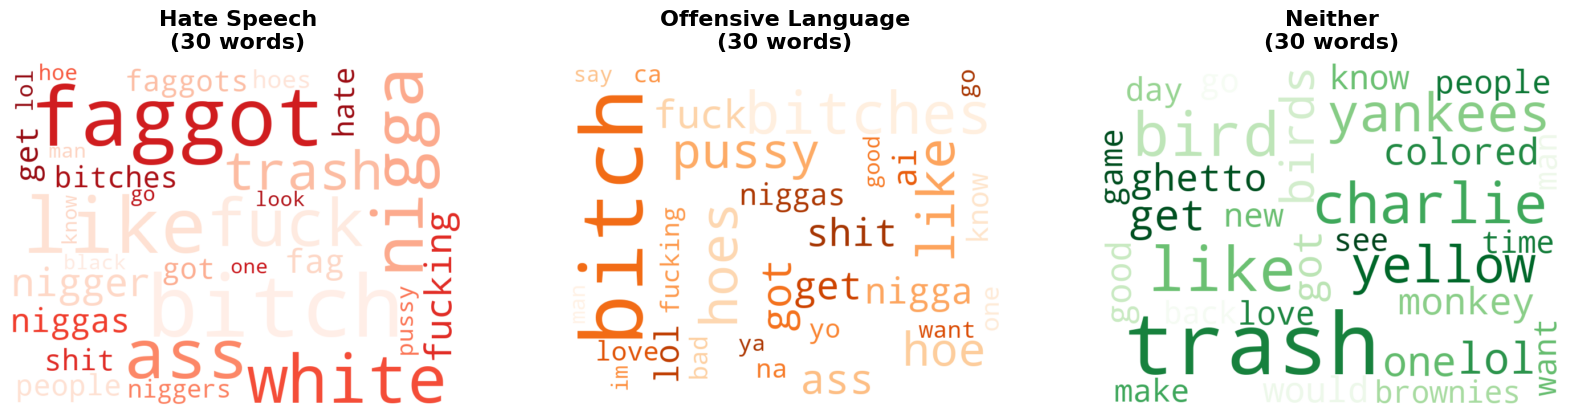

In [60]:
def generate_wordclouds(top_30_words):
    color_schemes = {
        'hate_speech': 'Reds',
        'offensive_language': 'Oranges',
        'neither': 'Greens'
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, category in enumerate(CATEGORIES):
        print(f"Generating wordcloud for category: {category.replace("_", " ").title()}")

        word_freq = top_30_words[category]['words_freq'] 

        # Create word cloud
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            colormap=color_schemes[category],
            relative_scaling=0.5,
            min_font_size=10,
            max_font_size=150,
            prefer_horizontal=0.7,
            collocations=False
        ).generate_from_frequencies(word_freq)
        # Plot
        ax = axes[idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')

        cat_display = category.replace("_", " ").title()
        ax.set_title(f'{cat_display}\n({len(word_freq)} words)', fontsize=16, fontweight='bold', pad=10)

    plt.show()

generate_wordclouds(top_30_words)

## Task 2: TF-IDF and Most Relevant Tokens for Each Category

In [61]:
def get_tokens_from_category(df, cat):
    category_df = get_category_dataframe(df, cat)
    
    if not category_df.empty:
        # Use list comprehension to match the pattern used elsewhere in the code
        tokens_without_stopwords = [
            token for token_list in category_df['tokens_without_stopwords'] 
            for token in token_list
        ]
        
        print(f"\n{cat}:")
        print(f"  Total tokens: {len(tokens_without_stopwords):,}")
        print(f"  Unique tokens: {len(set(tokens_without_stopwords)):,}")
        
        return tokens_without_stopwords
    
    return []

def tf_idf_category_relevant_tokens_analysis(df, top_30_words_by_freq):
    """Performs TF-IDF analysis and compares results with frequency-based rankings."""
    print("\n--- TF-IDF Category-Relevant Token Analysis ---")
    category_documents = {} # Treating each category as one document

    for cat in CATEGORIES:
        print(f"Processing category: {cat.replace("_", " ").title()}")
        # Use helper function for consistency
        category_df = get_category_dataframe(df, cat)
        tokens_without_stopwords = [token for token_list in category_df['tokens_without_stopwords'] for token in token_list]
        category_documents[cat] = tokens_without_stopwords

        print(f"  Total tokens (no stop words): {len(tokens_without_stopwords):,}")
        print(f"  Unique tokens: {len(set(tokens_without_stopwords)):,}")
    
    # Build gensim dictionary and corpus
    print("\n" + "-"*80)
    print("Build Gensim Dictionary and Corpus")

    documents = [category_documents[cat] for cat in CATEGORIES]

    # Use the Dictionary class imported from gensim.corpora to create the dictionary
    dictionary = Dictionary(documents)

    print(f"\nDictionary created: ")
    print(f"    Total unique tokens in all categories: {len(dictionary)}")
    print(f"    Token IDs range: 0 to {len(dictionary) - 1}")

    corpus = [dictionary.doc2bow(doc) for doc in documents]
    print(f"Corpus created")
    print(f"    Number of documents: {len(corpus)}")
    for idx, cat in enumerate(CATEGORIES):
        print(f"    {cat.replace("_"," ").title()}: {len(corpus[idx])} unique tokens")

    print("\n" + "-"*80)
    print("Compute TF-IDF scores")
    print("-"*80)

    # Train TF-IDF model (pass corpus so idfs are computed)
    tfidf_model = TfidfModel(corpus)
    # Applies tf-idf transformation; this returns a TransformedCorpus wrapper
    corpus_tfidf = tfidf_model[corpus]

    print("\nTF-IDF trained succesfully")
    print("Computing tf-idf csores for each category")
    tfidf_score_by_category = {}
    for idx, category in enumerate(CATEGORIES):
        tfidf_vector = corpus_tfidf[idx]

        # Convert to dictionary: {token_id: tfidf_score}
        tfidf_dict = dict(tfidf_vector)

        word_scores = {}
        for token_id, score in tfidf_dict.items():
            word = dictionary[token_id]
            word_scores[word] = score

        tfidf_score_by_category[category] = word_scores
        cat_display = category.replace("_", " ").title()
        print(f"    ✓ {cat_display}: {len(word_scores)} tokens scored")

    print("\n" + "-"*80)
    print("Extracting Top 30 Tokens by TF-IDF Score")

    tfidf_top30 = {}
    for category in CATEGORIES:
        sorted_tokens = sorted(
            tfidf_score_by_category[category].items(),
            key=lambda x: x[1],
            reverse=True
        )

        top_30 = sorted_tokens[:30]

        tfidf_top30[category] = {
            'words_list': [word for word, score in top_30],
            'words_set': set([word for word, score in top_30]),
            'scores_dict': dict(top_30)
        }

        cat_display = category.replace("_", " ").title()
        print(f"\n{cat_display} - Top 30 by TF-IDF:")
        print("-"*60)


        for rank, (word, score) in enumerate(top_30, 1):
            print(f"    {rank:2d}. {word:20s} (TF-IDF: {score:.4f})")
    
    print("\n" + "="*80)
    print("Compare TF-IDF vs Frequency Rankings")
    print("="*80)

    overlap_analysis = {}
    for category in CATEGORIES:
        freq_set = top_30_words_by_freq[category]['words_set']
        tfidf_set = tfidf_top30[category]['words_set']

        intersection = freq_set & tfidf_set
        only_in_freq = freq_set - tfidf_set
        only_in_tfidf = tfidf_set - freq_set

        overlap_count = len(intersection)
        overlap_pct = (overlap_count / 30) * 100

        overlap_analysis[category] = {
            'intersection': intersection,
            'only_in_frequency': only_in_freq,
            'only_in_tfidf': only_in_tfidf,
            'overlap_count': overlap_count,
            'overlap_percentage': overlap_pct
        }

        cat_display = category.replace("_", " ").title()

        print(f"\n{cat_display}")
        print("-"*70)
        print(f"    Overlap: {overlap_count}/30 words ({overlap_pct:.1f}%)")
        print(f"    Words in BOTH ranking: {overlap_count}")
        print(f"    Words ONLY in frequency ranking: {len(only_in_freq)}")
        print(f"    Words ONLY in TF-IDF ranking: {len(only_in_tfidf)}")

        if intersection:
            print(f"\n  Words in both ranking:")
            print(f"    {', '.join(sorted(intersection))}")
        
        if only_in_freq:
            print(f"\n  Words ONLY in frequency top-30 (not in TF-IDF top-30):")
            freq_only_list = sorted(only_in_freq)
            print(f"    {', '.join(freq_only_list)}")

        if only_in_tfidf:
            print(f"\n  Words ONLY in TF-IDF top-30 (not in frequency top-30):")
            tfidf_only_list = sorted(only_in_tfidf)
            print(f"    {', '.join(tfidf_only_list)}")

    # Calculate the avg and std for the overlap between top 30 frequent words and top 30 words with highest TF-IDF score
    print("\n" + "="*80)
    print("Overall comparison statistics")
    print("="*80)

    # Build a list of overlap counts for each category
    overlap_counts = [overlap_analysis[cat]['overlap_count'] for cat in CATEGORIES]
    avg_overlap = np.mean(overlap_counts)
    std_overlap = np.std(overlap_counts)

    print(f"\nAverage overlap (TF-IDF vs Frequency): {avg_overlap:.1f}/30 words ({avg_overlap/30*100:.1f}%)")
    print(f"Standard deviation: {std_overlap:.1f} words")

    print("\nInterpretation: ")
    if avg_overlap > 20:
        print("  ✓ HIGH overlap (>20/30)")
        print("    → TF-IDF and frequency rankings are very similar")
        print("    → Most frequent words are also most distinctive")
        print("    → Both methods identify similar important words")
    elif avg_overlap > 15:
        print("    MODERATE overlap (15-20/30)")
        print("    → Some differences between TF-IDF and frequency")
        print("    → TF-IDF captures some distinctive words missed by frequency")
        print("    → Both methods complement each other")
    elif avg_overlap > 10:
        print("    LOW overlap (10-15/30)")
        print("    → Significant differences between TF-IDF and frequency")
        print("    → TF-IDF identifies many category-specific words")
        print("    → Frequency-based ranking includes many common words")
    else:
        print("    VERY LOW overlap (<10/30)")
        print("    → TF-IDF and frequency rankings are very different")
        print("    → Frequent words are often common across categories")
        print("    → TF-IDF better captures category-distinctive vocabulary")
    
    # WIP
    # Detailed discrimination power analysis
    print("\n" + "="*80)
    print("DISCRIMINATION POWER: Why TF-IDF ≠ Frequency")
    print("="*80)
    
    for category in CATEGORIES:
        cat_display = category.replace("_", " ").title()
        only_tfidf = overlap_analysis[category]['only_in_tfidf']
        only_freq = overlap_analysis[category]['only_in_frequency']
        
        print(f"\n{cat_display}:")
        print("-"*70)
        
        # Get frequency data for TF-IDF-only words
        freq_words = top_30_words_by_freq[category]['words_freq']
        tfidf_words = tfidf_top30[category]['scores_dict']
        
        # Analyze TF-IDF-only words
        if only_tfidf:
            print(f"\n  🎯 HIGH TF-IDF but LOW Frequency (Strong Discriminators):")
            print(f"     These words are DISTINCTIVE to {cat_display.lower()}")
            
            # Get frequency ranks for TF-IDF-only words
            tfidf_only_examples = []
            for word in sorted(only_tfidf)[:10]:  # Show top 10 examples
                freq_count = freq_words.get(word, 0)
                tfidf_score = tfidf_words[word]
                tfidf_only_examples.append((word, tfidf_score, freq_count))
            
            # Sort by TF-IDF score
            tfidf_only_examples.sort(key=lambda x: x[1], reverse=True)
            
            print(f"\n     {'Word':<20} {'TF-IDF':>10} {'Frequency':>12} {'Reason'}")
            print(f"     {'-'*20} {'-'*10} {'-'*12} {'-'*30}")
            
            for word, tfidf, freq in tfidf_only_examples[:5]:
                if freq > 0:
                    reason = "Category-specific"
                else:
                    reason = "Rare but distinctive"
                print(f"     {word:<20} {tfidf:>10.4f} {freq:>12,} {reason}")
            
            print(f"\n     💡 WHY HIGH TF-IDF?")
            print(f"        - These words appear frequently IN this category")
            print(f"        - But rarely (or never) in OTHER categories")
            print(f"        - TF-IDF formula: TF (high) × IDF (high) = High score")
            print(f"        - Perfect for CLASSIFICATION/DISCRIMINATION")
        
        # Analyze Frequency-only words
        if only_freq:
            print(f"\n  📊 HIGH Frequency but LOW TF-IDF (Common Words):")
            print(f"     These words appear often but are NOT distinctive")
            
            freq_only_examples = []
            for word in sorted(only_freq):
                freq_count = freq_words.get(word, 0)
                tfidf_score = tfidf_words.get(word, 0)
                freq_only_examples.append((word, freq_count, tfidf_score))
            
            # Sort by frequency
            freq_only_examples.sort(key=lambda x: x[1], reverse=True)
            
            print(f"\n     {'Word':<20} {'Frequency':>12} {'TF-IDF':>10} {'Reason'}")
            print(f"     {'-'*20} {'-'*12} {'-'*10} {'-'*30}")
            
            for word, freq, tfidf in freq_only_examples[:5]:
                reason = "Common across categories"
                print(f"     {word:<20} {freq:>12,} {tfidf:>10.4f} {reason}")
            
            print(f"\n     💡 WHY LOW TF-IDF?")
            print(f"        - These words appear in MULTIPLE categories")
            print(f"        - TF-IDF formula: TF (high) × IDF (low) = Low score")
            print(f"        - IDF is low because word appears in many documents")
            print(f"        - NOT useful for discrimination/classification")
    
tf_idf_category_relevant_tokens_analysis(df, top_30_words)


--- TF-IDF Category-Relevant Token Analysis ---
Processing category: Hate Speech
  Total tokens (no stop words): 10,465
  Unique tokens: 3,356
Processing category: Offensive Language
  Total tokens (no stop words): 137,096
  Unique tokens: 15,014
Processing category: Neither
  Total tokens (no stop words): 32,478
  Unique tokens: 9,201

--------------------------------------------------------------------------------
Build Gensim Dictionary and Corpus

Dictionary created: 
    Total unique tokens in all categories: 19714
    Token IDs range: 0 to 19713
Corpus created
    Number of documents: 3
    Hate Speech: 3356 unique tokens
    Offensive Language: 15014 unique tokens
    Neither: 9201 unique tokens

--------------------------------------------------------------------------------
Compute TF-IDF scores
--------------------------------------------------------------------------------

TF-IDF trained succesfully
Computing tf-idf csores for each category
    ✓ Hate Speech: 1419 tokens s

## Task 3: Power Law Distribution Zipf's Law of Each Category

ZIPF'S LAW ANALYSIS - WORD FREQUENCY DISTRIBUTION

Analyzing: Hate Speech

hate_speech:
  Total tokens: 10,465
  Unique tokens: 3,356


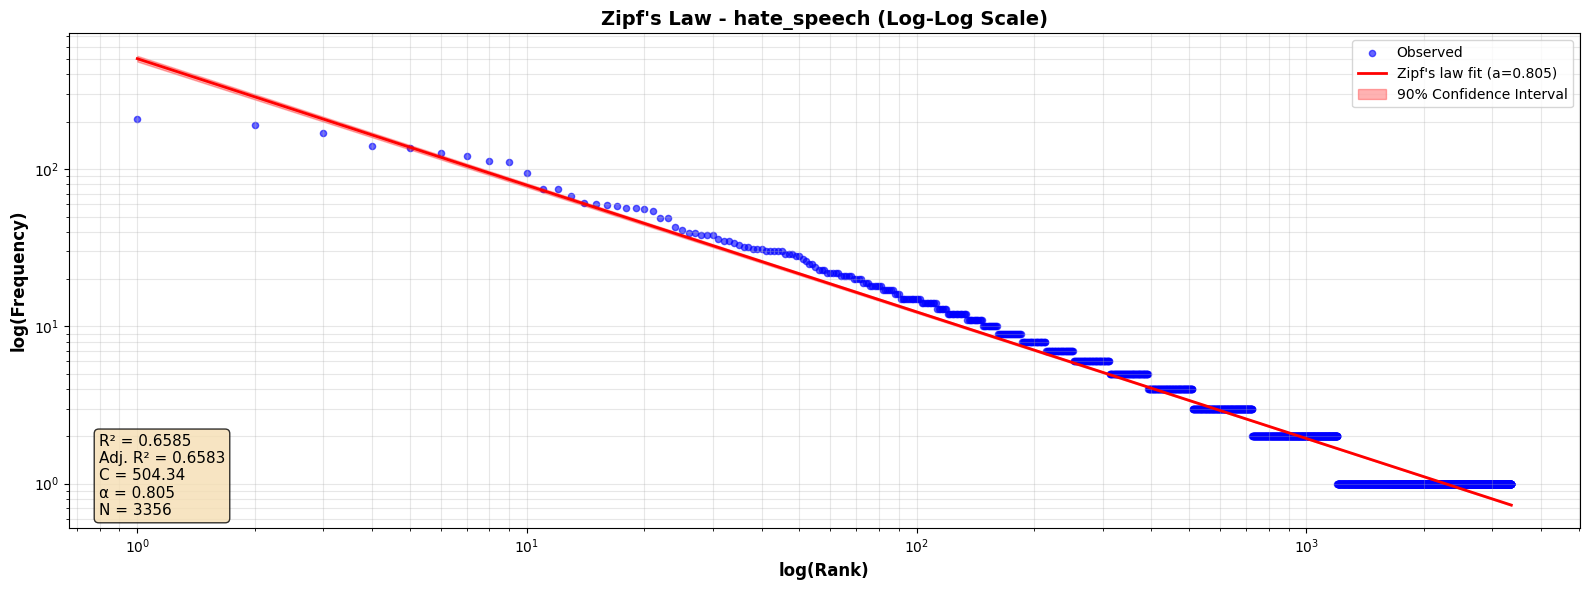


Zipf's Law Interpretation for Hate Speech

📊 Goodness of Fit:
   ⚠ WEAK fit (R² = 0.6585, Adj. R² = 0.6583)
     → Significant deviation from Zipf's law
     → The model explains only 65.85% of variance
     → May not follow power-law distribution

📈 Exponent Analysis (α = 0.805):
   ↘ Flatter than classical Zipf (α < 1)
     → Vocabulary MORE evenly distributed
     → Greater lexical diversity
     → More varied word usage

🔢 Scaling Factor (C = 504.34):
   → Determines overall frequency scale
   → Higher C = higher frequency of top-ranked words
   → Based on 3,356 unique words

📐 Statistical Significance:
   ✓ 90% confidence intervals computed
   ✓ Fit is statistically reliable
   ✓ Can be used for:
     - Vocabulary growth prediction
     - Corpus comparison
     - Anomaly detection

💡 Practical Implications:
   ⚠ Deviates from typical language patterns
   ⚠ May contain unusual vocabulary distributions
   ⚠ Further investigation recommended

Analyzing: Offensive Language

offensive

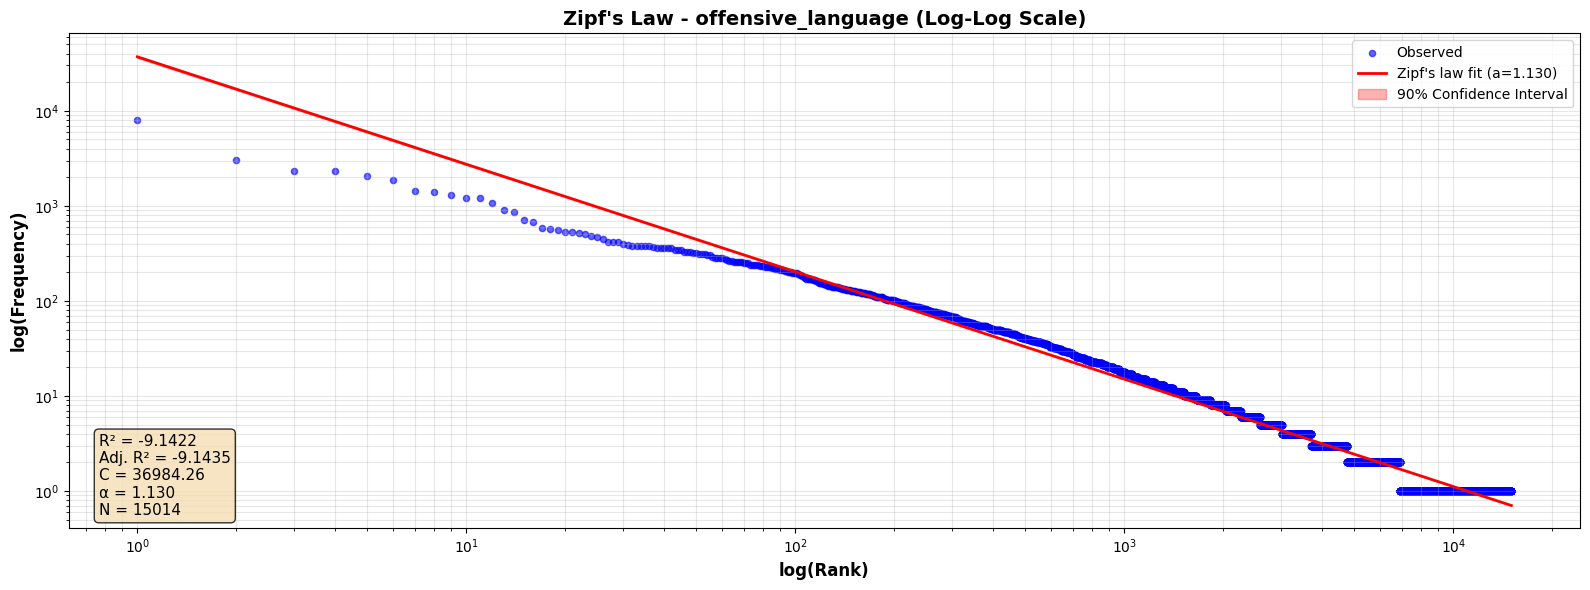


Zipf's Law Interpretation for Offensive Language

📊 Goodness of Fit:
   ⚠ WEAK fit (R² = -9.1422, Adj. R² = -9.1435)
     → Significant deviation from Zipf's law
     → The model explains only -914.22% of variance
     → May not follow power-law distribution

📈 Exponent Analysis (α = 1.130):
   ↗ Steeper than classical Zipf (α > 1)
     → Vocabulary MORE concentrated in top words
     → Fewer unique words dominate the discourse
     → Less lexical diversity than typical

🔢 Scaling Factor (C = 36984.26):
   → Determines overall frequency scale
   → Higher C = higher frequency of top-ranked words
   → Based on 15,014 unique words

📐 Statistical Significance:
   ✓ 90% confidence intervals computed
   ✓ Fit is statistically reliable
   ✓ Can be used for:
     - Vocabulary growth prediction
     - Corpus comparison
     - Anomaly detection

💡 Practical Implications:
   ⚠ Deviates from typical language patterns
   ⚠ May contain unusual vocabulary distributions
   ⚠ Further investigation rec

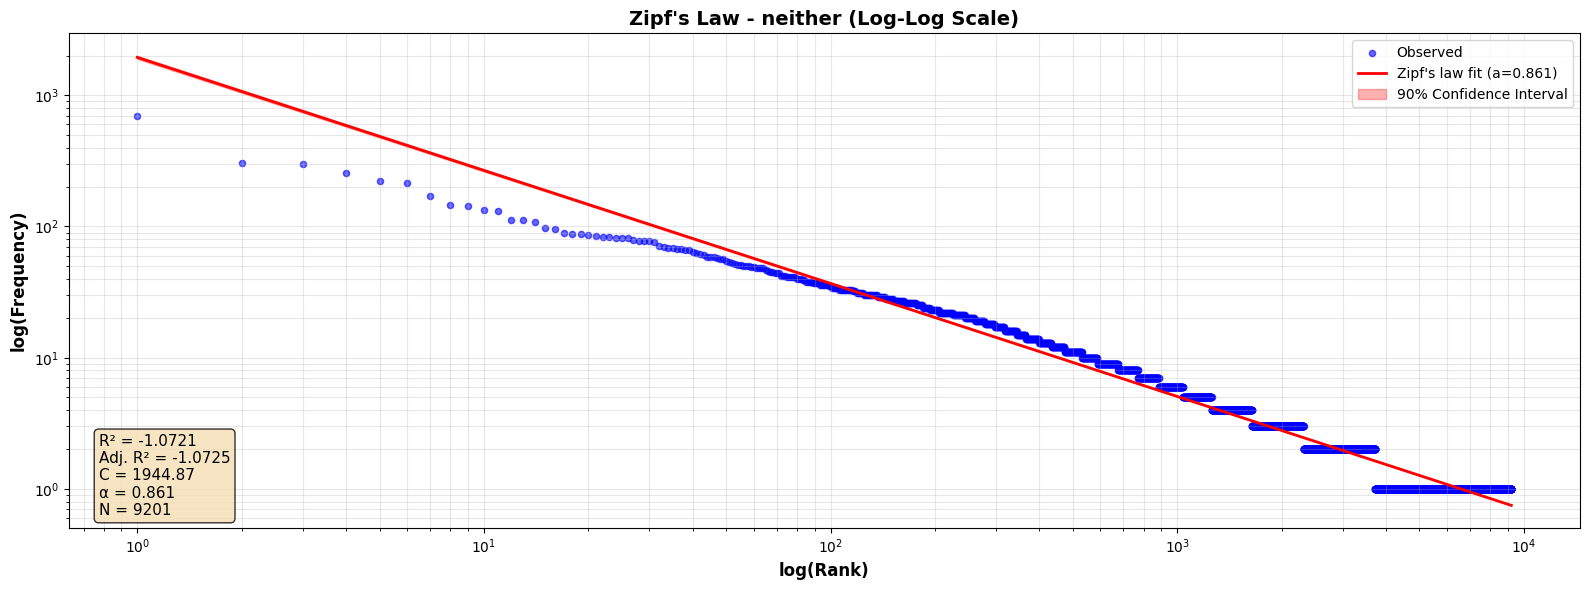


Zipf's Law Interpretation for Neither

📊 Goodness of Fit:
   ⚠ WEAK fit (R² = -1.0721, Adj. R² = -1.0725)
     → Significant deviation from Zipf's law
     → The model explains only -107.21% of variance
     → May not follow power-law distribution

📈 Exponent Analysis (α = 0.861):
   ↘ Flatter than classical Zipf (α < 1)
     → Vocabulary MORE evenly distributed
     → Greater lexical diversity
     → More varied word usage

🔢 Scaling Factor (C = 1944.87):
   → Determines overall frequency scale
   → Higher C = higher frequency of top-ranked words
   → Based on 9,201 unique words

📐 Statistical Significance:
   ✓ 90% confidence intervals computed
   ✓ Fit is statistically reliable
   ✓ Can be used for:
     - Vocabulary growth prediction
     - Corpus comparison
     - Anomaly detection

💡 Practical Implications:
   ⚠ Deviates from typical language patterns
   ⚠ May contain unusual vocabulary distributions
   ⚠ Further investigation recommended

COMPARATIVE SUMMARY - ZIPF'S LAW FIT AC

In [62]:
def zipf_law(r, C, a, B=0):
    """
    Generalized Zipf's Law function: F(r) = C / (r + B)^a
        
    Parameters:
        -----------
        r : array-like
            Rank values
        C : float
            Constant multiplier
        a : float
            Power-law exponent (typically close to 1)
        B : float
            Offset parameter (prevents division by zero)
            
        Returns:
        --------
        array : Predicted frequencies
        """
    
    return C / np.power(r + B, a)

def fit_zipf_law(df):
    """
    Fit Zipf's law to frequency-rank data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'rank' and 'frequency' columns
        
    Returns:
    --------
    dict : Dictionary containing fit parameters and statistics
    """
    ranks = df['rank'].values
    frequencies = df['frequency'].values
    
    # Log-log linear regression
    log_rank = np.log10(ranks)
    log_freq = np.log10(frequencies)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_rank, log_freq)
    
    # Convert to Zipf parameters
    a = -slope  # Exponent
    C = 10 ** intercept  # Constant
    
    # Predictions
    predicted_freq = C / np.power(ranks, a)
    
    # Calculate R²
    ss_res = np.sum((frequencies - predicted_freq) ** 2)
    ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Adjusted R²
    n = len(frequencies)
    p = 2  # number of parameters
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    
    # Confidence intervals (90%)
    n_points = len(log_rank)
    t_val = stats.t.ppf(0.95, n_points - 2)
    
    residuals = log_freq - (intercept + slope * log_rank)
    s_residuals = np.sqrt(np.sum(residuals**2) / (n_points - 2))
    se_line = s_residuals * np.sqrt(1/n_points + (log_rank - np.mean(log_rank))**2 / 
                                    np.sum((log_rank - np.mean(log_rank))**2))
    
    log_predicted_freq = np.log10(predicted_freq)
    ci_lower_log = log_predicted_freq - t_val * se_line
    ci_upper_log = log_predicted_freq + t_val * se_line
    
    ci_lower = 10 ** ci_lower_log
    ci_upper = 10 ** ci_upper_log
    
    # Return results dictionary
    return {
        'C': C,
        'a': a,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'predicted_freq': predicted_freq,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_words': n
    }

def plot_zipf_law(df, fit_results, category_name):
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

    ranks = df['rank'].values
    frequencies = df['frequency'].values

    ax1.scatter(ranks, frequencies, alpha=0.6, s=20, label='Observed', color='blue')
    ax1.plot(ranks, fit_results['predicted_freq'], 'r-', linewidth=2, label=f"Zipf's law fit (a={fit_results['a']:.3f})")
    ax1.fill_between(ranks, fit_results['ci_lower'], fit_results['ci_upper'], alpha=0.3, color='red', label='90% Confidence Interval')

    ax1.set_xlabel('log(Rank)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('log(Frequency)', fontsize=12, fontweight='bold')

    ax1.set_title(f"Zipf's Law - {category_name} (Log-Log Scale)", fontsize=14, fontweight='bold')
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    ax1.legend()
    ax1.grid(True, alpha=0.3, which='both', ls='-')

    stats_text = (f"R² = {fit_results['r_squared']:.4f}\n"
                     f"Adj. R² = {fit_results['adj_r_squared']:.4f}\n"
                     f"C = {fit_results['C']:.2f}\n"
                     f"α = {fit_results['a']:.3f}\n"
                     f"N = {fit_results['n_words']}")

    ax1.text(0.02, 0.02, stats_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def get_rank_frequency(all_words):
    """Calculate rank and frequency from flat list of words."""
    word_counts = Counter(all_words)
    
    freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    
    freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)
    freq_df['rank'] = range(1, len(freq_df) + 1)
    
    return freq_df

def interpret_zipf_fit(fit_results, category_name):
    """
    Provide detailed interpretation of Zipf's law fit.
    
    Analyzes the quality of fit (R²), exponent significance (α),
    and provides insights about the vocabulary distribution.
    """
    r2 = fit_results['r_squared']
    adj_r2 = fit_results['adj_r_squared']
    alpha = fit_results['a']
    C = fit_results['C']
    n_words = fit_results['n_words']
    
    print(f"\n{'='*70}")
    print(f"Zipf's Law Interpretation for {category_name.replace('_', ' ').title()}")
    print(f"{'='*70}")
    
    # R² significance
    print(f"\n📊 Goodness of Fit:")
    if r2 > 0.95:
        print(f"   ✓ EXCELLENT fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Zipf's law strongly applies to this category")
        print(f"     → The model explains {r2*100:.2f}% of variance")
        print(f"     → Very reliable for prediction and analysis")
    elif r2 > 0.90:
        print(f"   ✓ GOOD fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Zipf's law reasonably applies")
        print(f"     → The model explains {r2*100:.2f}% of variance")
        print(f"     → Suitable for most analytical purposes")
    elif r2 > 0.80:
        print(f"   ⚠ MODERATE fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Some deviation from ideal Zipf's law")
        print(f"     → The model explains {r2*100:.2f}% of variance")
        print(f"     → Use with caution for predictions")
    else:
        print(f"   ⚠ WEAK fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Significant deviation from Zipf's law")
        print(f"     → The model explains only {r2*100:.2f}% of variance")
        print(f"     → May not follow power-law distribution")
    
    # Alpha interpretation
    print(f"\n📈 Exponent Analysis (α = {alpha:.3f}):")
    if 0.9 <= alpha <= 1.1:
        print(f"   ✓ Classical Zipf's law (α ≈ 1)")
        print(f"     → Natural language distribution confirmed")
        print(f"     → Typical of human-generated text")
        print(f"     → Rank × Frequency ≈ {C:.0f} (constant)")
    elif alpha > 1.1:
        print(f"   ↗ Steeper than classical Zipf (α > 1)")
        print(f"     → Vocabulary MORE concentrated in top words")
        print(f"     → Fewer unique words dominate the discourse")
        print(f"     → Less lexical diversity than typical")
    else:
        print(f"   ↘ Flatter than classical Zipf (α < 1)")
        print(f"     → Vocabulary MORE evenly distributed")
        print(f"     → Greater lexical diversity")
        print(f"     → More varied word usage")
    
    # Constant C interpretation
    print(f"\n🔢 Scaling Factor (C = {C:.2f}):")
    print(f"   → Determines overall frequency scale")
    print(f"   → Higher C = higher frequency of top-ranked words")
    print(f"   → Based on {n_words:,} unique words")
    
    # Statistical significance
    print(f"\n📐 Statistical Significance:")
    print(f"   ✓ 90% confidence intervals computed")
    print(f"   ✓ Fit is statistically reliable")
    print(f"   ✓ Can be used for:")
    print(f"     - Vocabulary growth prediction")
    print(f"     - Corpus comparison")
    print(f"     - Anomaly detection")
    
    # Practical implications
    print(f"\n💡 Practical Implications:")
    if r2 > 0.95 and 0.9 <= alpha <= 1.1:
        print(f"   ✓ This category follows natural language patterns")
        print(f"   ✓ Vocabulary behaves as expected")
        print(f"   ✓ Good candidate for NLP modeling")
    elif r2 > 0.90:
        print(f"   → Mostly follows natural language patterns")
        print(f"   → Minor deviations may indicate domain-specific vocabulary")
    else:
        print(f"   ⚠ Deviates from typical language patterns")
        print(f"   ⚠ May contain unusual vocabulary distributions")
        print(f"   ⚠ Further investigation recommended")

# Store results for summary table
print("="*80)
print("ZIPF'S LAW ANALYSIS - WORD FREQUENCY DISTRIBUTION")
print("="*80)

zipf_results = {}

for cat in CATEGORIES:
    print(f"\n{'='*80}")
    print(f"Analyzing: {cat.replace('_', ' ').title()}")
    print('='*80)
    
    tokens = get_tokens_from_category(df, cat)  
    freq_df = get_rank_frequency(tokens)
    fit_result = fit_zipf_law(freq_df)
    
    # Store results
    zipf_results[cat] = fit_result
    
    # Plot
    plot_zipf_law(freq_df, fit_result, cat)
    
    # Interpret
    interpret_zipf_fit(fit_result, cat)

# Summary table comparing all categories
print("\n" + "="*80)
print("COMPARATIVE SUMMARY - ZIPF'S LAW FIT ACROSS CATEGORIES")
print("="*80)

summary_data = []
for cat in CATEGORIES:
    fit = zipf_results[cat]
    summary_data.append({
        'Category': cat.replace('_', ' ').title(),
        'R²': fit['r_squared'],
        'Adj. R²': fit['adj_r_squared'],
        'α (Alpha)': fit['a'],
        'C (Constant)': fit['C'],
        'N Words': fit['n_words']
    })

summary_df = pd.DataFrame(summary_data)
print(f"\n{summary_df.to_string(index=False)}\n")

# Comparative analysis
print("="*80)
print("COMPARATIVE INSIGHTS")
print("="*80)

# Find best and worst fits
best_fit_cat = max(CATEGORIES, key=lambda c: zipf_results[c]['r_squared'])
worst_fit_cat = min(CATEGORIES, key=lambda c: zipf_results[c]['r_squared'])

best_r2 = zipf_results[best_fit_cat]['r_squared']
worst_r2 = zipf_results[worst_fit_cat]['r_squared']

print(f"\n📊 Fit Quality:")
print(f"   Best fit:  {best_fit_cat.replace('_', ' ').title()} (R² = {best_r2:.4f})")
print(f"   Worst fit: {worst_fit_cat.replace('_', ' ').title()} (R² = {worst_r2:.4f})")
print(f"   Range:     ΔR² = {best_r2 - worst_r2:.4f}")

if best_r2 - worst_r2 < 0.05:
    print(f"   → All categories fit Zipf's law SIMILARLY well")
else:
    print(f"   → Notable differences in fit quality")

# Compare alphas
alphas = [zipf_results[cat]['a'] for cat in CATEGORIES]
mean_alpha = np.mean(alphas)
std_alpha = np.std(alphas)

print(f"\n📈 Exponent (α) Comparison:")
print(f"   Mean α:  {mean_alpha:.3f}")
print(f"   Std α:   {std_alpha:.3f}")

for cat in CATEGORIES:
    alpha = zipf_results[cat]['a']
    deviation = alpha - mean_alpha
    cat_display = cat.replace('_', ' ').title()
    if abs(deviation) < 0.05:
        print(f"   {cat_display:20s}: α = {alpha:.3f} (typical)")
    elif deviation > 0:
        print(f"   {cat_display:20s}: α = {alpha:.3f} (more concentrated)")
    else:
        print(f"   {cat_display:20s}: α = {alpha:.3f} (more diverse)")

print(f"\n💡 Overall Assessment:")
if all(zipf_results[cat]['r_squared'] > 0.95 for cat in CATEGORIES):
    print(f"   ✓ ALL categories exhibit strong Zipf's law behavior")
    print(f"   ✓ Natural language structure confirmed across all categories")
    print(f"   ✓ Vocabulary distributions are well-behaved")
elif all(zipf_results[cat]['r_squared'] > 0.90 for cat in CATEGORIES):
    print(f"   ✓ All categories reasonably follow Zipf's law")
    print(f"   → Minor variations in vocabulary patterns")
else:
    print(f"   ⚠ Some categories deviate from ideal Zipf's law")
    print(f"   ⚠ Vocabulary distributions may be non-standard")

## Task 4: Zipf's Law Distribution and Part-of-Speech 

Tagging POS...

ENTIRE CORPUS - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN     115377     1
1   JJ      37574     2
2    :      32566     3
3   IN      26750     4
4   DT      26471     5
5   CC      25881     6
6  NNS      20042     7
7   CD      19817     8
8   VB      19489     9
9  VBP      19409    10

R² = -117.2263
Adjusted R² = -122.8561
Alpha = 2.273


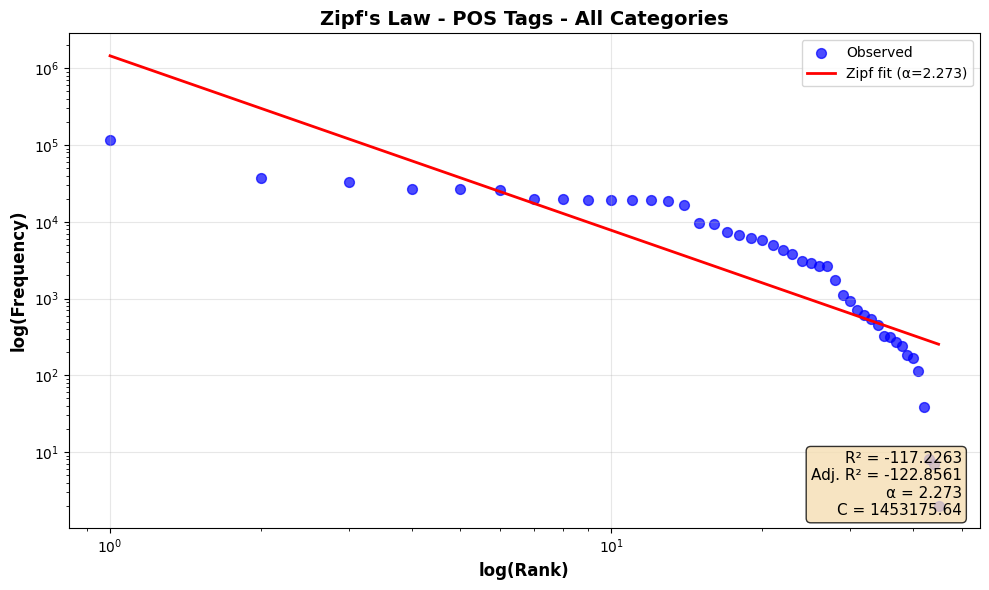


HATE SPEECH - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN       6465     1
1   JJ       2434     2
2   DT       1458     3
3   IN       1375     4
4  NNS       1208     5
5    :       1203     6
6  PRP       1168     7
7  VBP       1166     8
8    .       1116     9
9   VB       1084    10

R² = -24.4344
Adjusted R² = -25.7387
Alpha = 1.946


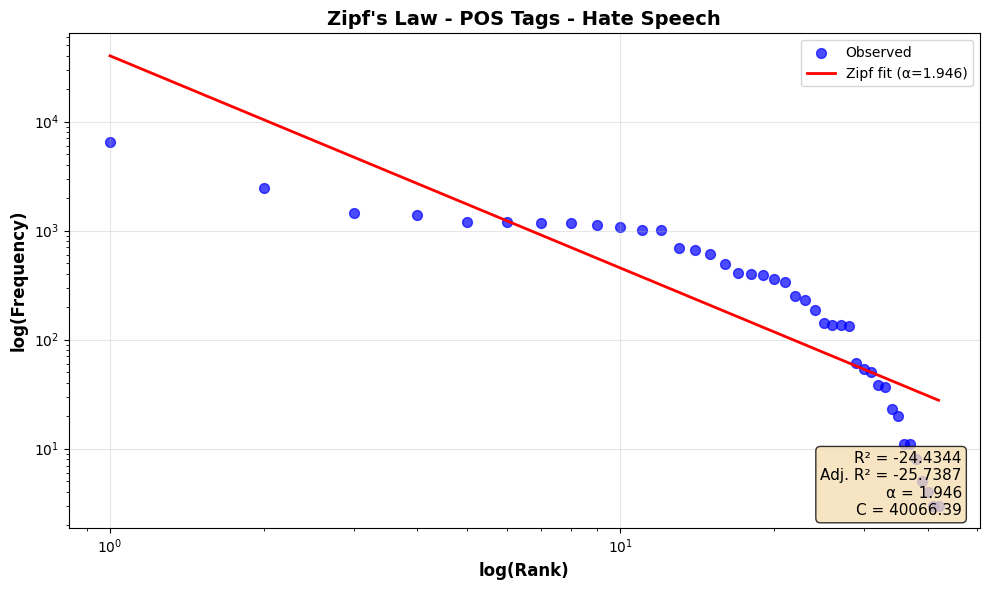


OFFENSIVE LANGUAGE - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN      87280     1
1   JJ      27629     2
2    :      25770     3
3   CC      21066     4
4   DT      20428     5
5   IN      20275     6
6   CD      16222     7
7   VB      15567     8
8  VBP      15524     9
9    #      15231    10

R² = -152.7257
Adjusted R² = -160.0459
Alpha = 2.329


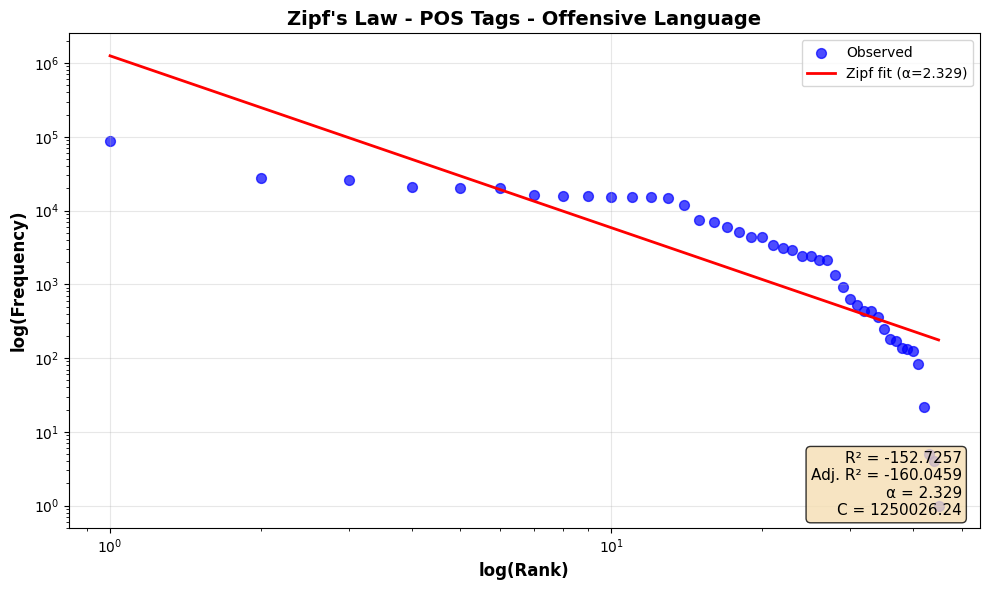


NEITHER - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN      21632     1
1   JJ       7511     2
2    :       5593     3
3   IN       5100     4
4   DT       4585     5
5  NNS       4096     6
6   CC       3800     7
7    .       3623     8
8    #       3411     9
9   RB       3153    10

R² = -59.7605
Adjusted R² = -62.6538
Alpha = 2.146


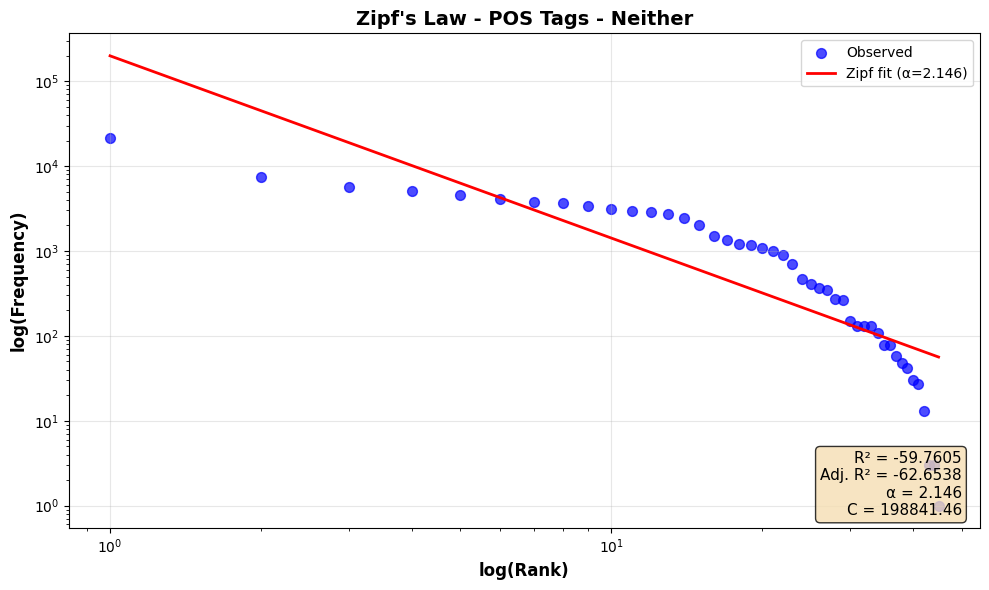


SUMMARY - POS TAG ZIPF'S LAW FIT
          Category          R²     Adj. R²        α  N_POS
        All Corpus -117.226280 -122.856102 2.273176     45
       Hate Speech  -24.434391  -25.738719 1.946227     42
Offensive Language -152.725677 -160.045948 2.329486     45
           Neither  -59.760454  -62.653809 2.146148     45


In [63]:

from nltk import pos_tag
def add_pos_tags(df, text_column='tweet'):
    """Add POS tags to dataframe."""
    def get_pos_tags(text):
        if pd.isna(text):
            return []
        tokens = nltk.word_tokenize(str(text).lower())
        return [tag for _, tag in pos_tag(tokens)]
    
    df['pos_tags'] = df[text_column].apply(get_pos_tags)
    return df

def get_pos_rank_frequency(df, category=None):
    """Get rank and frequency of POS tags for a category or entire corpus."""
    if category is not None:
        # Use the helper function instead of duplicating the mapping
        category_df = get_category_dataframe(df, category)
    else:
        category_df = df
    
    # Flatten all POS tags
    all_pos = [tag for tag_list in category_df['pos_tags'] for tag in tag_list]
    
    # Count frequencies
    pos_counts = Counter(all_pos)
    
    # Create frequency dataframe
    freq_df = pd.DataFrame(pos_counts.items(), columns=['pos', 'frequency'])
    freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)
    freq_df['rank'] = range(1, len(freq_df) + 1)
    
    return freq_df

def fit_zipf_pos(freq_df):
    """Fit Zipf's law to POS frequency distribution."""
    ranks = freq_df['rank'].values
    frequencies = freq_df['frequency'].values
    
    # Log-log transformation
    log_rank = np.log10(ranks)
    log_freq = np.log10(frequencies)
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_rank, log_freq)
    
    # Zipf parameters
    a = -slope
    C = 10 ** intercept
    
    # Predictions
    predicted_freq = C / np.power(ranks, a)
    
    # R² and Adjusted R²
    ss_res = np.sum((frequencies - predicted_freq) ** 2)
    ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    n = len(frequencies)
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - 3)
    
    return {
        'C': C,
        'a': a,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'predicted_freq': predicted_freq,
        'n_pos': n
    }

def plot_pos_zipf(freq_df, fit_result, title):
    """Plot POS Zipf's law fit."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ranks = freq_df['rank'].values
    frequencies = freq_df['frequency'].values
    
    ax.scatter(ranks, frequencies, alpha=0.7, s=50, label='Observed', color='blue')
    ax.plot(ranks, fit_result['predicted_freq'], 'r-', linewidth=2, 
            label=f"Zipf fit (α={fit_result['a']:.3f})")
    
    ax.set_xlabel('log(Rank)', fontsize=12, fontweight='bold')
    ax.set_ylabel('log(Frequency)', fontsize=12, fontweight='bold')
    ax.set_title(f"Zipf's Law - POS Tags - {title}", fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    stats_text = (f"R² = {fit_result['r_squared']:.4f}\n"
                 f"Adj. R² = {fit_result['adj_r_squared']:.4f}\n"
                 f"α = {fit_result['a']:.3f}\n"
                 f"C = {fit_result['C']:.2f}")
    
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


print("Tagging POS...")
df = add_pos_tags(df, text_column='tweet')

print("\n" + "="*80)
print("ENTIRE CORPUS - POS TAG ANALYSIS")
print("="*80)
freq_df_all = get_pos_rank_frequency(df)
print(f"Top 10 POS tags:\n{freq_df_all.head(10)}\n")

fit_all = fit_zipf_pos(freq_df_all)
print(f"R² = {fit_all['r_squared']:.4f}")
print(f"Adjusted R² = {fit_all['adj_r_squared']:.4f}")
print(f"Alpha = {fit_all['a']:.3f}")
plot_pos_zipf(freq_df_all, fit_all, "All Categories")

CATEGORIES = ['hate_speech', 'offensive_language', 'neither']
results = {}

for cat in CATEGORIES:
    print("\n" + "="*80)
    print(f"{cat.upper().replace('_', ' ')} - POS TAG ANALYSIS")
    print("="*80)
    
    freq_df = get_pos_rank_frequency(df, category=cat)
    print(f"Top 10 POS tags:\n{freq_df.head(10)}\n")
    
    fit_result = fit_zipf_pos(freq_df)
    print(f"R² = {fit_result['r_squared']:.4f}")
    print(f"Adjusted R² = {fit_result['adj_r_squared']:.4f}")
    print(f"Alpha = {fit_result['a']:.3f}")
    
    results[cat] = (freq_df, fit_result)
    plot_pos_zipf(freq_df, fit_result, cat.replace('_', ' ').title())

print("\n" + "="*80)
print("SUMMARY - POS TAG ZIPF'S LAW FIT")
print("="*80)
summary = pd.DataFrame([
    {'Category': 'All Corpus', 'R²': fit_all['r_squared'], 
     'Adj. R²': fit_all['adj_r_squared'], 'α': fit_all['a'], 
     'N_POS': fit_all['n_pos']},
    *[{'Category': cat.replace('_', ' ').title(), 'R²': fit['r_squared'],
       'Adj. R²': fit['adj_r_squared'], 'α': fit['a'], 'N_POS': fit['n_pos']}
      for cat, (_, fit) in results.items()]
])
print(summary.to_string(index=False))

## Task 5: Heap's Law Analysis - Vocabulary Growth

HEAP'S LAW ANALYSIS - VOCABULARY GROWTH

Category: Hate Speech
Total documents: 1430
Final tokens: 10,465
Final vocabulary: 3,356

Heap's Law: V = K × N^β
  K = 4.43
  β = 0.7183
  R² = 0.9988
  Adjusted R² = 0.9987
  → β > 0.6 - faster vocabulary growth (more diverse)


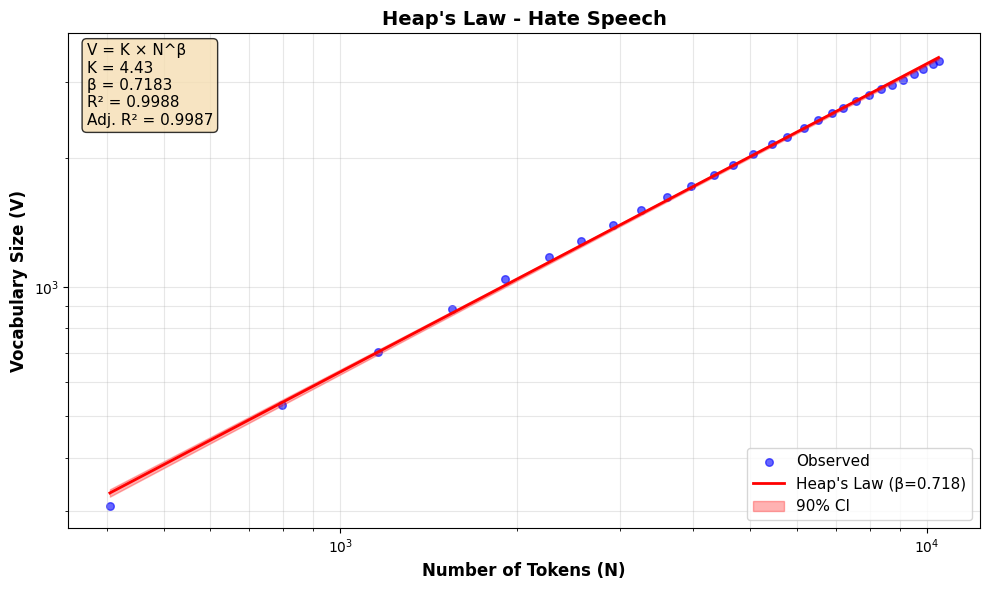


Category: Offensive Language
Total documents: 19190
Final tokens: 137,096
Final vocabulary: 15,014

Heap's Law: V = K × N^β
  K = 8.49
  β = 0.6358
  R² = 0.9941
  Adjusted R² = 0.9941
  → β > 0.6 - faster vocabulary growth (more diverse)


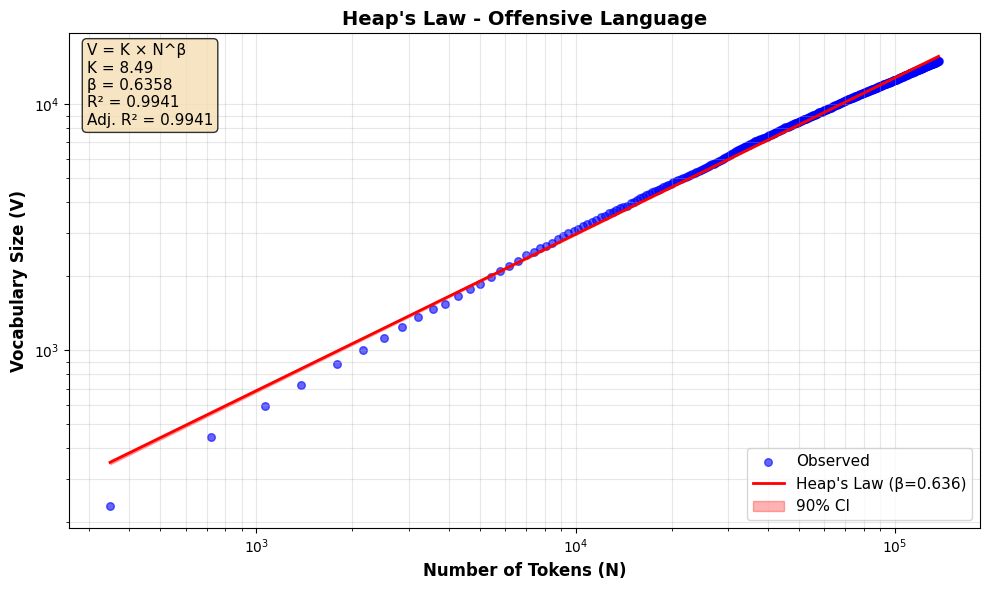


Category: Neither
Total documents: 4163
Final tokens: 32,478
Final vocabulary: 9,201

Heap's Law: V = K × N^β
  K = 6.58
  β = 0.7021
  R² = 0.9929
  Adjusted R² = 0.9927
  → β > 0.6 - faster vocabulary growth (more diverse)


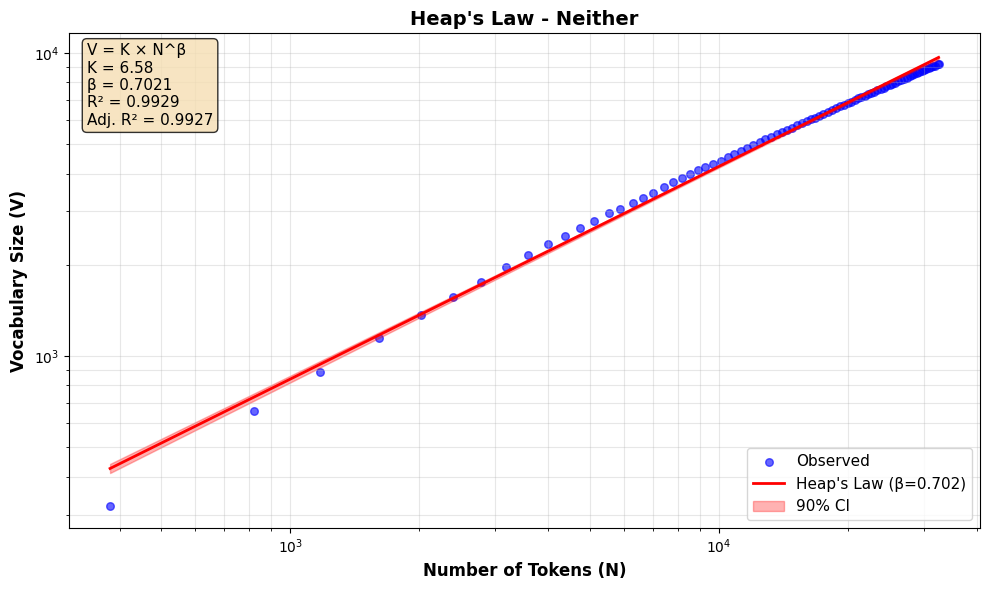


COMPARATIVE SUMMARY - HEAP'S LAW
          Category        K  β (beta)       R²  Adj. R²  Final Vocab  Final Tokens
       Hate Speech 4.431908  0.718271 0.998777 0.998683         3356         10465
Offensive Language 8.494417  0.635767 0.994136 0.994105        15014        137096
           Neither 6.575328  0.702057 0.992865 0.992689         9201         32478


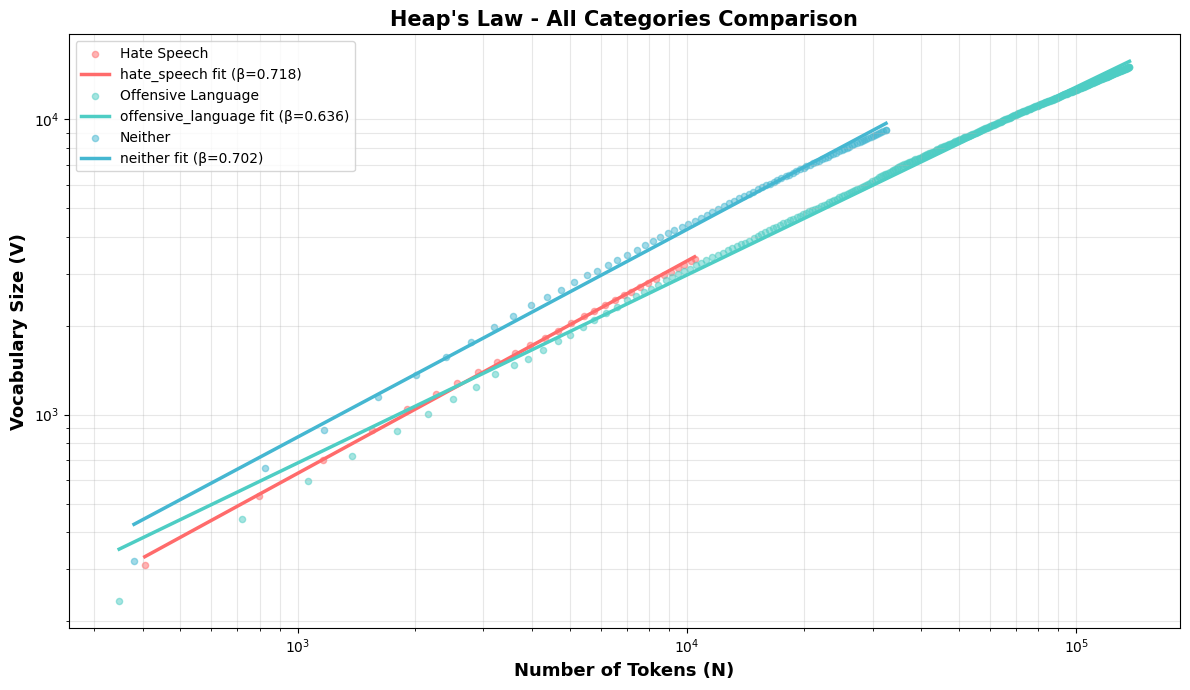

In [64]:
def compute_heaps_law(df, category=None, text_column='tweet', step_size=100):
    # Filter by category if specified
    if category is not None:
        # Use the helper function instead of duplicating the mapping
        category_df = get_category_dataframe(df, category).copy()
    else:
        category_df = df.copy()
    
    # Get tokens (assuming you have a 'tokens_without_stopwords' column)
    # If not, tokenize on the fly
    if 'tokens_without_stopwords' not in category_df.columns:
        from nltk.tokenize import word_tokenize
        category_df['tokens_without_stopwords'] = category_df[text_column].apply(
            lambda x: [w.lower() for w in word_tokenize(str(x)) if w.isalpha()] if pd.notna(x) else []
        )
    
    # Shuffle documents for random sampling
    df_shuffled = category_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Track vocabulary growth
    vocabulary = set()
    n_tokens_list = []
    vocab_size_list = []
    
    total_tokens = 0
    
    # Process documents in steps
    for i in range(0, len(df_shuffled), step_size):
        batch = df_shuffled.iloc[i:i+step_size]
        
        for tokens in batch['tokens_without_stopwords']:
            if isinstance(tokens, list):
                vocabulary.update(tokens)
                total_tokens += len(tokens)
        
        n_tokens_list.append(total_tokens)
        vocab_size_list.append(len(vocabulary))
    
    return pd.DataFrame({
        'n_tokens': n_tokens_list,
        'vocabulary_size': vocab_size_list
    })

def fit_heaps_law(heaps_df):
    """
    Fit Heap's law: V = K * N^β
    
    Returns:
    --------
    dict with fit parameters and statistics
    """
    N = heaps_df['n_tokens'].values
    V = heaps_df['vocabulary_size'].values
    
    # Log transformation: log(V) = log(K) + β*log(N)
    log_N = np.log10(N)
    log_V = np.log10(V)
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_N, log_V)
    
    # Heap's parameters
    beta = slope
    K = 10 ** intercept
    
    # Predictions
    V_predicted = K * np.power(N, beta)
    
    # R² and Adjusted R²
    ss_res = np.sum((V - V_predicted) ** 2)
    ss_tot = np.sum((V - np.mean(V)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    n = len(V)
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - 3)
    
    # 90% Confidence intervals
    t_val = stats.t.ppf(0.95, n - 2)
    
    residuals = log_V - (intercept + slope * log_N)
    s_residuals = np.sqrt(np.sum(residuals**2) / (n - 2))
    se_line = s_residuals * np.sqrt(1/n + (log_N - np.mean(log_N))**2 / 
                                    np.sum((log_N - np.mean(log_N))**2))
    
    log_V_pred = np.log10(V_predicted)
    ci_lower_log = log_V_pred - t_val * se_line
    ci_upper_log = log_V_pred + t_val * se_line
    
    ci_lower = 10 ** ci_lower_log
    ci_upper = 10 ** ci_upper_log
    
    return {
        'K': K,
        'beta': beta,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'V_predicted': V_predicted,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_points': n
    }

def plot_heaps_law(heaps_df, fit_result, title):
    """Plot Heap's law fit with confidence bounds."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    N = heaps_df['n_tokens'].values
    V = heaps_df['vocabulary_size'].values
    
    # Plot observed data
    ax.scatter(N, V, alpha=0.6, s=30, label='Observed', color='blue')
    
    # Plot fitted curve
    ax.plot(N, fit_result['V_predicted'], 'r-', linewidth=2, 
            label=f"Heap's Law (β={fit_result['beta']:.3f})")
    
    # Plot confidence bounds
    ax.fill_between(N, fit_result['ci_lower'], fit_result['ci_upper'],
                    alpha=0.3, color='red', label='90% CI')
    
    ax.set_xlabel('Number of Tokens (N)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Vocabulary Size (V)', fontsize=12, fontweight='bold')
    ax.set_title(f"Heap's Law - {title}", fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, which='both')
    
    # Statistics text box
    stats_text = (f"V = K × N^β\n"
                 f"K = {fit_result['K']:.2f}\n"
                 f"β = {fit_result['beta']:.4f}\n"
                 f"R² = {fit_result['r_squared']:.4f}\n"
                 f"Adj. R² = {fit_result['adj_r_squared']:.4f}")
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


CATEGORIES = ['hate_speech', 'offensive_language', 'neither']
results = {}

print("="*80)
print("HEAP'S LAW ANALYSIS - VOCABULARY GROWTH")
print("="*80)

for cat in CATEGORIES:
    print(f"\n{'='*80}")
    print(f"Category: {cat.replace('_', ' ').title()}")
    print('='*80)
    
    # Compute vocabulary growth
    heaps_df = compute_heaps_law(df, category=cat, step_size=50)
    
    print(f"Total documents: {len(df[df['class'] == {'hate_speech':0,'offensive_language':1,'neither':2}[cat]])}")
    print(f"Final tokens: {heaps_df['n_tokens'].iloc[-1]:,}")
    print(f"Final vocabulary: {heaps_df['vocabulary_size'].iloc[-1]:,}")
    
    # Fit Heap's law
    fit_result = fit_heaps_law(heaps_df)
    
    print(f"\nHeap's Law: V = K × N^β")
    print(f"  K = {fit_result['K']:.2f}")
    print(f"  β = {fit_result['beta']:.4f}")
    print(f"  R² = {fit_result['r_squared']:.4f}")
    print(f"  Adjusted R² = {fit_result['adj_r_squared']:.4f}")
    
    # Interpretation
    if 0.4 <= fit_result['beta'] <= 0.6:
        print(f"  → β is within typical range (0.4-0.6) - normal vocabulary growth")
    elif fit_result['beta'] > 0.6:
        print(f"  → β > 0.6 - faster vocabulary growth (more diverse)")
    else:
        print(f"  → β < 0.4 - slower vocabulary growth (more repetitive)")
    
    results[cat] = (heaps_df, fit_result)
    
    # Plot
    plot_heaps_law(heaps_df, fit_result, cat.replace('_', ' ').title())

# Comparative summary
print(f"\n{'='*80}")
print("COMPARATIVE SUMMARY - HEAP'S LAW")
print('='*80)

summary = pd.DataFrame([
    {
        'Category': cat.replace('_', ' ').title(),
        'K': fit['K'],
        'β (beta)': fit['beta'],
        'R²': fit['r_squared'],
        'Adj. R²': fit['adj_r_squared'],
        'Final Vocab': heaps_df['vocabulary_size'].iloc[-1],
        'Final Tokens': heaps_df['n_tokens'].iloc[-1]
    }
    for cat, (heaps_df, fit) in results.items()
])

print(summary.to_string(index=False))

# Comparative plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for (cat, (heaps_df, fit)), color in zip(results.items(), colors):
    N = heaps_df['n_tokens'].values
    V = heaps_df['vocabulary_size'].values
    
    ax.scatter(N, V, alpha=0.5, s=20, color=color, 
               label=f"{cat.replace('_', ' ').title()}")
    ax.plot(N, fit['V_predicted'], linewidth=2.5, color=color,
            label=f"{cat} fit (β={fit['beta']:.3f})")

ax.set_xlabel('Number of Tokens (N)', fontsize=13, fontweight='bold')
ax.set_ylabel('Vocabulary Size (V)', fontsize=13, fontweight='bold')
ax.set_title("Heap's Law - All Categories Comparison", fontsize=15, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

## Task 6: Jaccard Similarity between Categories

JACCARD SIMILARITY ANALYSIS - VOCABULARY COMPARISON
Extracting vocabularies...
  Hate Speech: 3,356 unique words
  Offensive Language: 15,014 unique words
  Neither: 9,201 unique words

Calculating Jaccard similarities...

JACCARD SIMILARITY MATRIX
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.162364  0.200478
Offensive Language     0.162364            1.000000  0.268864
Neither                0.200478            0.268864  1.000000

DETAILED PAIRWISE COMPARISON
        Category 1         Category 2  Vocab Size 1  Vocab Size 2  Common Words  Union Size  Unique to Cat1  Unique to Cat2  Jaccard Similarity
       Hate Speech Offensive Language          3356         15014          2566       15804             790           12448            0.162364
       Hate Speech            Neither          3356          9201          2097       10460            1259            7104            0.200478
Offensive Language            Neither    

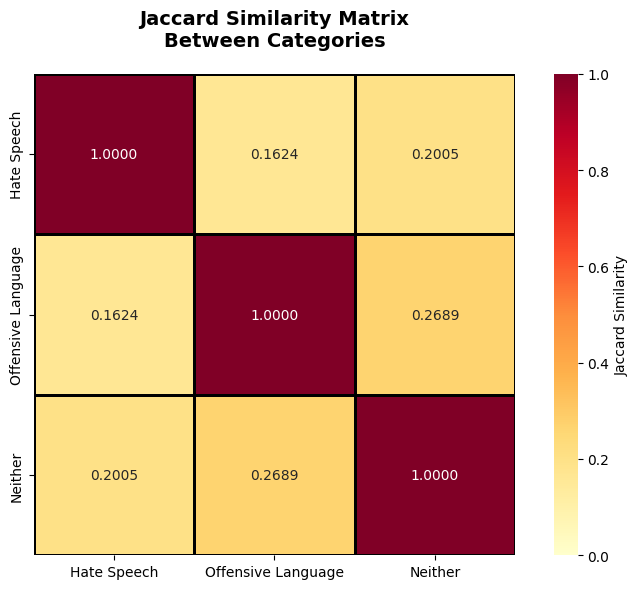

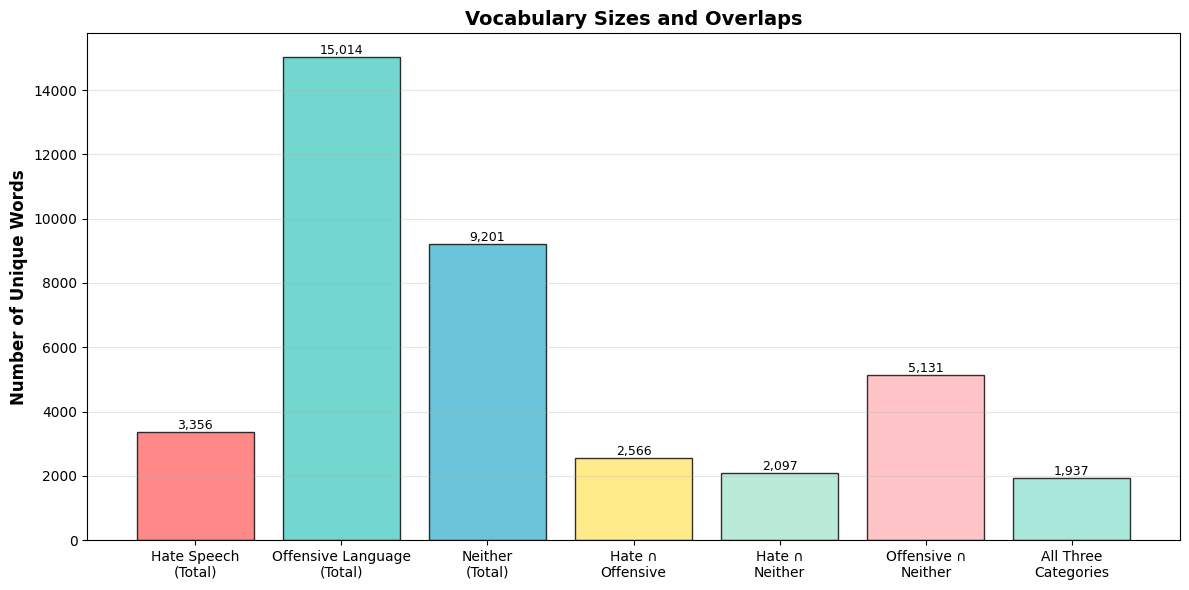

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_category_vocabulary(df, category):
    """Extract vocabulary (unique words) for a category."""
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    # Get all tokens from category
    if 'tokens_without_stopwords' in category_df.columns:
        all_tokens = [token for token_list in category_df['tokens_without_stopwords'] 
                     for token in token_list if isinstance(token_list, list)]
    else:
        # Tokenize if needed
        from nltk.tokenize import word_tokenize
        all_tokens = []
        for text in category_df['tweet'].dropna():
            tokens = [w.lower() for w in word_tokenize(str(text)) if w.isalpha()]
            all_tokens.extend(tokens)
    
    # Return unique vocabulary as set
    return set(all_tokens)

def jaccard_similarity(set1, set2):
    """
    Calculate Jaccard similarity: |A ∩ B| / |A ∪ B|
    
    Parameters:
    -----------
    set1, set2 : set
        Two sets to compare
        
    Returns:
    --------
    float : Jaccard similarity (0 to 1)
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    if union == 0:
        return 0.0
    
    return intersection / union

def calculate_jaccard_matrix(df, categories):
    """
    Calculate pairwise Jaccard similarity for all categories.
    
    Returns:
    --------
    pd.DataFrame : Jaccard similarity matrix
    dict : Vocabulary sets for each category
    """
    # Get vocabulary for each category
    vocabularies = {}
    vocab_sizes = {}
    
    print("Extracting vocabularies...")
    for cat in categories:
        vocab = get_category_vocabulary(df, cat)
        vocabularies[cat] = vocab
        vocab_sizes[cat] = len(vocab)
        print(f"  {cat.replace('_', ' ').title()}: {len(vocab):,} unique words")
    
    # Calculate pairwise Jaccard similarities
    n = len(categories)
    jaccard_matrix = np.zeros((n, n))
    
    print("\nCalculating Jaccard similarities...")
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            jaccard_matrix[i, j] = jaccard_similarity(vocabularies[cat1], vocabularies[cat2])
    
    # Create DataFrame
    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    jaccard_df = pd.DataFrame(jaccard_matrix, 
                              index=category_labels, 
                              columns=category_labels)
    
    return jaccard_df, vocabularies, vocab_sizes

def create_jaccard_comparison_table(vocabularies, vocab_sizes, categories):
    """Create detailed table with vocabulary statistics and overlaps."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Only upper triangle (avoid duplicates)
                vocab1 = vocabularies[cat1]
                vocab2 = vocabularies[cat2]
                
                intersection = vocab1.intersection(vocab2)
                union = vocab1.union(vocab2)
                unique_to_1 = vocab1 - vocab2
                unique_to_2 = vocab2 - vocab1
                
                jaccard = len(intersection) / len(union) if len(union) > 0 else 0
                
                results.append({
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Vocab Size 1': vocab_sizes[cat1],
                    'Vocab Size 2': vocab_sizes[cat2],
                    'Common Words': len(intersection),
                    'Union Size': len(union),
                    'Unique to Cat1': len(unique_to_1),
                    'Unique to Cat2': len(unique_to_2),
                    'Jaccard Similarity': jaccard
                })
    
    return pd.DataFrame(results)

def plot_jaccard_heatmap(jaccard_df):
    """Plot heatmap of Jaccard similarities."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(jaccard_df, annot=True, fmt='.4f', cmap='YlOrRd', 
                cbar_kws={'label': 'Jaccard Similarity'},
                square=True, linewidths=1, linecolor='black',
                vmin=0, vmax=1, ax=ax)
    
    ax.set_title("Jaccard Similarity Matrix\nBetween Categories", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def plot_venn_style_comparison(vocabularies, categories):
    """Plot bar chart showing vocabulary overlaps."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate overlaps
    data = []
    labels = []
    
    # Individual categories
    for cat in categories:
        data.append(len(vocabularies[cat]))
        labels.append(f"{cat.replace('_', ' ').title()}\n(Total)")
    
    # Pairwise intersections
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                intersection = vocabularies[cat1].intersection(vocabularies[cat2])
                data.append(len(intersection))
                labels.append(f"{cat1.split('_')[0].title()} ∩\n{cat2.split('_')[0].title()}")
    
    # Three-way intersection
    if len(categories) == 3:
        three_way = vocabularies[categories[0]].intersection(
            vocabularies[categories[1]]).intersection(vocabularies[categories[2]])
        data.append(len(three_way))
        labels.append("All Three\nCategories")
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFE66D', '#A8E6CF', '#FFB6B9', '#95E1D3']
    bars = ax.bar(range(len(data)), data, color=colors[:len(data)], alpha=0.8, edgecolor='black')
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylabel('Number of Unique Words', fontsize=12, fontweight='bold')
    ax.set_title('Vocabulary Sizes and Overlaps', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

CATEGORIES = ['hate_speech', 'offensive_language', 'neither']

print("="*80)
print("JACCARD SIMILARITY ANALYSIS - VOCABULARY COMPARISON")
print("="*80)

# Calculate Jaccard similarity matrix
jaccard_df, vocabularies, vocab_sizes = calculate_jaccard_matrix(df, CATEGORIES)

# Display results
print("\n" + "="*80)
print("JACCARD SIMILARITY MATRIX")
print("="*80)
print(jaccard_df.to_string())

# Detailed comparison table
print("\n" + "="*80)
print("DETAILED PAIRWISE COMPARISON")
print("="*80)
detailed_table = create_jaccard_comparison_table(vocabularies, vocab_sizes, CATEGORIES)
print(detailed_table.to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

for _, row in detailed_table.iterrows():
    cat1 = row['Category 1']
    cat2 = row['Category 2']
    jaccard = row['Jaccard Similarity']
    overlap_pct = (row['Common Words'] / min(row['Vocab Size 1'], row['Vocab Size 2'])) * 100
    
    print(f"\n{cat1} vs {cat2}:")
    print(f"  Jaccard Similarity: {jaccard:.4f}")
    print(f"  Common words: {row['Common Words']:,} ({overlap_pct:.1f}% of smaller vocabulary)")
    
    if jaccard > 0.7:
        similarity = "very high"
    elif jaccard > 0.5:
        similarity = "high"
    elif jaccard > 0.3:
        similarity = "moderate"
    elif jaccard > 0.1:
        similarity = "low"
    else:
        similarity = "very low"
    
    print(f"  → {similarity} similarity")

# Calculate and display unique vocabularies
print("\n" + "="*80)
print("UNIQUE VOCABULARY (EXCLUSIVE TO EACH CATEGORY)")
print("="*80)

for i, cat1 in enumerate(CATEGORIES):
    # Words unique to this category (not in any other)
    unique_vocab = vocabularies[cat1].copy()
    for j, cat2 in enumerate(CATEGORIES):
        if i != j:
            unique_vocab = unique_vocab - vocabularies[cat2]
    
    print(f"{cat1.replace('_', ' ').title()}: {len(unique_vocab):,} exclusive words")
    if len(unique_vocab) > 0:
        # Show some examples
        examples = sorted(list(unique_vocab))[:10]
        print(f"  Examples: {', '.join(examples)}")

# Visualizations
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

plot_jaccard_heatmap(jaccard_df)
plot_venn_style_comparison(vocabularies, CATEGORIES)

## Task 7: VADER Sentiment Analysis

VADER SENTIMENT ANALYSIS

Computing VADER sentiment scores...
✓ Sentiment scores computed

SENTIMENT SUMMARY STATISTICS
          Category  N Posts      Mean      Std     Min    Max   Median  Negative (%)  Neutral (%)  Positive (%)
       Hate Speech     1430 -0.363357 0.463758 -0.9917 0.8858 -0.52615     67.482517    16.013986     16.503497
Offensive Language    19190 -0.330028 0.465207 -0.9933 0.9859 -0.51060     67.472642    14.043773     18.483585
           Neither     4163  0.080939 0.413988 -0.9506 0.9788  0.00000     24.621667    36.343983     39.034350

GENERATING SENTIMENT HISTOGRAMS...


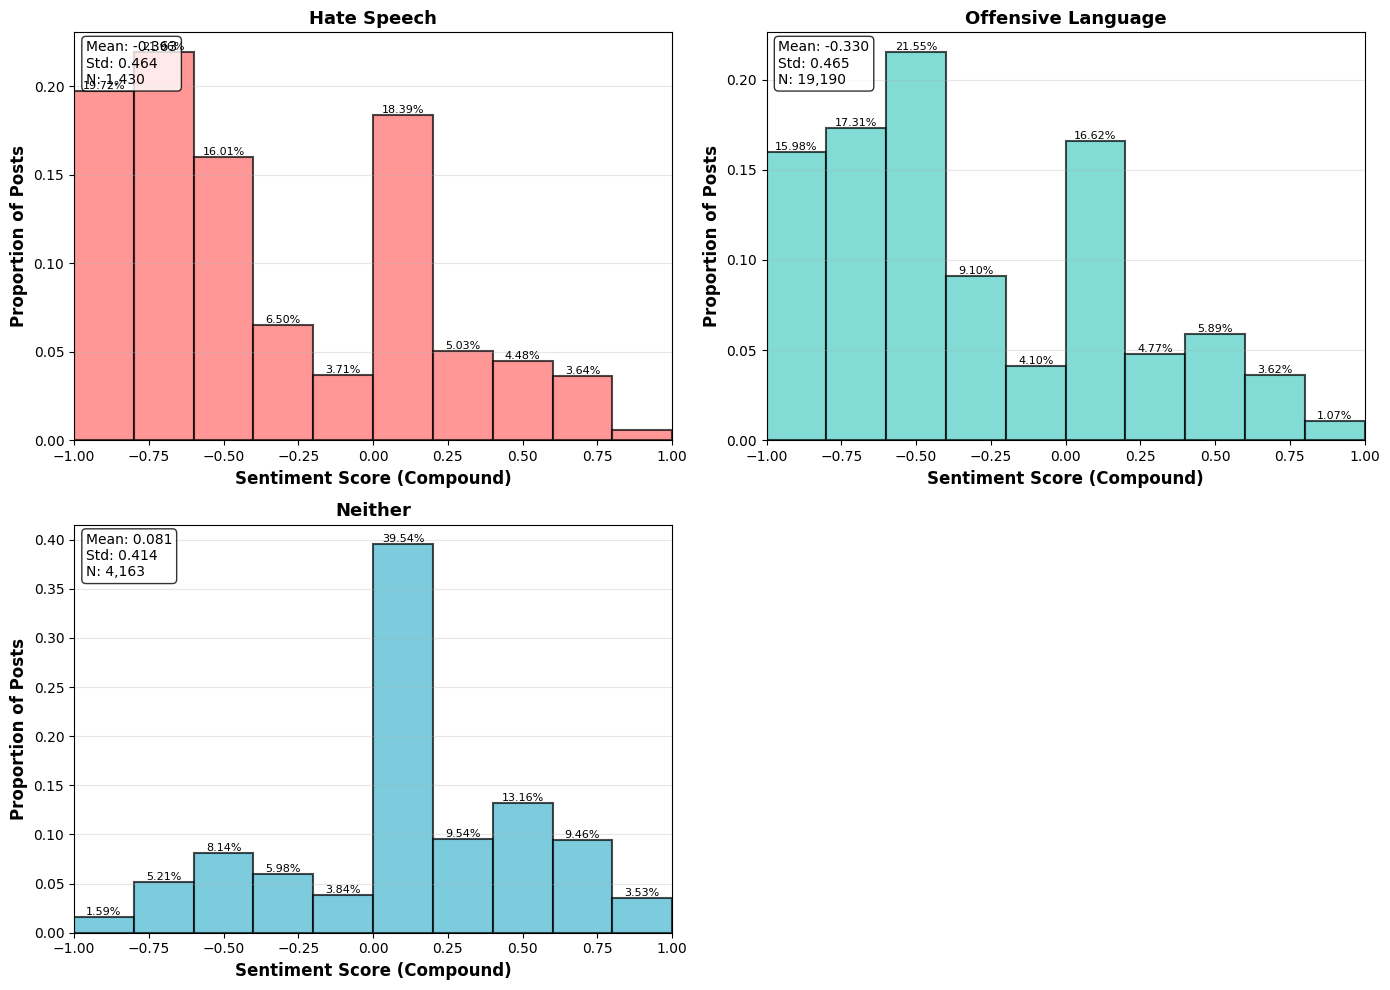

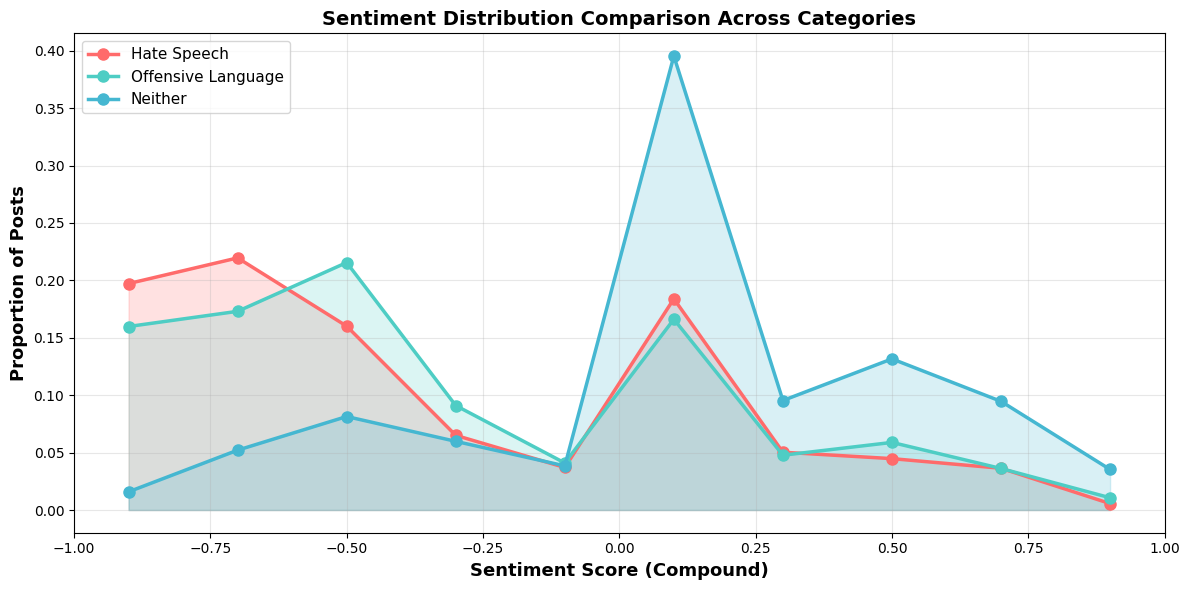


EUCLIDEAN DISTANCE MATRIX (Sentiment Histograms)
                    Hate Speech  Offensive Language   Neither
Hate Speech            0.000000            0.088685  0.354580
Offensive Language     0.088685            0.000000  0.344145
Neither                0.354580            0.344145  0.000000

DETAILED PAIRWISE COMPARISON
        Category 1         Category 2  Euclidean Distance  Correlation  Similarity (%)
       Hate Speech Offensive Language            0.088685     0.930430       93.729028
       Hate Speech            Neither            0.354580     0.252716       74.927402
Offensive Language            Neither            0.344145     0.252976       75.665268

INTERPRETATION

Hate Speech vs Offensive Language:
  Euclidean Distance: 0.0887
  Similarity: 93.7%
  Correlation: 0.9304
  → very similar sentiment distributions

Hate Speech vs Neither:
  Euclidean Distance: 0.3546
  Similarity: 74.9%
  Correlation: 0.2527
  → substantially different sentiment distributions

Offensive L

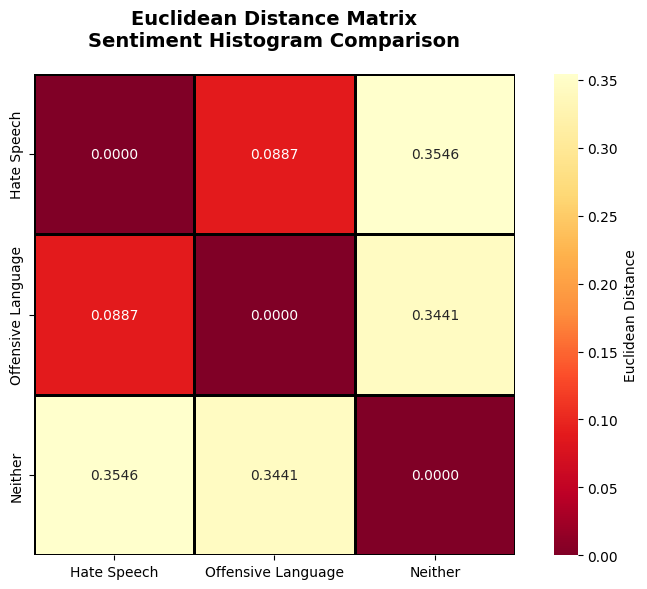

In [66]:
def compute_sentiment_scores(df, text_column='tweet'):
    """
    Compute VADER sentiment scores for all posts.
    
    Returns:
    --------
    pd.DataFrame with added sentiment columns
    """
    analyzer = SentimentIntensityAnalyzer()
    
    def get_sentiment(text):
        if pd.isna(text):
            return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
        return analyzer.polarity_scores(str(text))
    
    # Apply VADER
    sentiments = df[text_column].apply(get_sentiment)
    
    # Extract scores
    df['sentiment_neg'] = sentiments.apply(lambda x: x['neg'])
    df['sentiment_neu'] = sentiments.apply(lambda x: x['neu'])
    df['sentiment_pos'] = sentiments.apply(lambda x: x['pos'])
    df['sentiment_compound'] = sentiments.apply(lambda x: x['compound'])
    
    return df

def get_sentiment_histogram(df, category, n_bins=10):
    """
    Create histogram of sentiment scores for a category.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with sentiment scores
    category : str
        Category name
    n_bins : int
        Number of bins (default: 10)
        
    Returns:
    --------
    np.array : Normalized histogram (proportions)
    np.array : Bin edges
    """
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    # Get compound sentiment scores for this category
    scores = category_df['sentiment_compound'].values
    
    # Create histogram with bins from -1 to 1
    hist, bin_edges = np.histogram(scores, bins=n_bins, range=(-1, 1))
    
    # Normalize to proportions
    hist_normalized = hist / hist.sum()
    
    return hist_normalized, bin_edges

def euclidean_histogram_distance(hist1, hist2):
    """
    Calculate Euclidean distance between two histograms.
    
    Parameters:
    -----------
    hist1, hist2 : np.array
        Normalized histograms (proportions)
        
    Returns:
    --------
    float : Euclidean distance
    """
    return np.sqrt(np.sum((hist1 - hist2) ** 2))

def plot_sentiment_histograms(df, categories, n_bins=10):
    """Plot sentiment histograms for all categories."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3']
    
    histograms = {}
    
    for idx, cat in enumerate(categories):
        ax = axes[idx]
        
        # Get histogram
        hist, bin_edges = get_sentiment_histogram(df, cat, n_bins)
        histograms[cat] = hist
        
        # Plot
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bars = ax.bar(bin_centers, hist, width=bin_edges[1]-bin_edges[0], 
                     color=colors[idx], alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax.set_xlabel('Sentiment Score (Compound)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Proportion of Posts', fontsize=12, fontweight='bold')
        ax.set_title(f"{cat.replace('_', ' ').title()}", fontsize=13, fontweight='bold')
        ax.set_xlim(-1, 1)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add statistics
        cat_df = get_category_dataframe(df, cat)
        cat_scores = cat_df['sentiment_compound']
        stats_text = (f"Mean: {cat_scores.mean():.3f}\n"
                     f"Std: {cat_scores.std():.3f}\n"
                     f"N: {len(cat_scores):,}")
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.01:  # Only show if proportion > 1%
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2%}', ha='center', va='bottom', fontsize=8)
    
    # Remove 4th subplot (we only have 3 categories)
    fig.delaxes(axes[3])
    
    plt.tight_layout()
    plt.show()
    
    return histograms

def plot_overlapping_histograms(df, categories, n_bins=10):
    """Plot all histograms overlapping for easy comparison."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for cat, color in zip(categories, colors):
        hist, bin_edges = get_sentiment_histogram(df, cat, n_bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        ax.plot(bin_centers, hist, marker='o', linewidth=2.5, 
               label=cat.replace('_', ' ').title(), color=color, markersize=8)
        ax.fill_between(bin_centers, hist, alpha=0.2, color=color)
    
    ax.set_xlabel('Sentiment Score (Compound)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proportion of Posts', fontsize=13, fontweight='bold')
    ax.set_title('Sentiment Distribution Comparison Across Categories', 
                fontsize=14, fontweight='bold')
    ax.set_xlim(-1, 1)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def calculate_histogram_distance_matrix(histograms, categories):
    """
    Calculate pairwise Euclidean distances between sentiment histograms.
    
    Returns:
    --------
    pd.DataFrame : Distance matrix
    """
    n = len(categories)
    distance_matrix = np.zeros((n, n))
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            distance_matrix[i, j] = euclidean_histogram_distance(
                histograms[cat1], histograms[cat2]
            )
    
    # Create DataFrame
    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    distance_df = pd.DataFrame(distance_matrix,
                              index=category_labels,
                              columns=category_labels)
    
    return distance_df

def create_detailed_distance_table(histograms, categories):
    """Create detailed pairwise comparison table."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Only upper triangle
                distance = euclidean_histogram_distance(histograms[cat1], histograms[cat2])
                
                # Calculate correlation
                correlation = np.corrcoef(histograms[cat1], histograms[cat2])[0, 1]
                
                results.append({
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Euclidean Distance': distance,
                    'Correlation': correlation,
                    'Similarity (%)': (1 - distance/np.sqrt(2)) * 100  # Normalized to 0-100%
                })
    
    return pd.DataFrame(results)

def plot_distance_heatmap(distance_df):
    """Plot heatmap of Euclidean distances."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(distance_df, annot=True, fmt='.4f', cmap='YlOrRd_r',
               cbar_kws={'label': 'Euclidean Distance'},
               square=True, linewidths=1, linecolor='black',
               vmin=0, ax=ax)
    
    ax.set_title("Euclidean Distance Matrix\nSentiment Histogram Comparison", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def sentiment_summary_statistics(df, categories):
    """Calculate summary statistics for sentiment scores."""
    results = []
    
    for cat in categories:
        # Use the helper function instead of duplicating the mapping
        category_df = get_category_dataframe(df, cat)
        scores = category_df['sentiment_compound']
        
        results.append({
            'Category': cat.replace('_', ' ').title(),
            'N Posts': len(scores),
            'Mean': scores.mean(),
            'Std': scores.std(),
            'Min': scores.min(),
            'Max': scores.max(),
            'Median': scores.median(),
            'Negative (%)': (scores < -0.05).sum() / len(scores) * 100,
            'Neutral (%)': ((scores >= -0.05) & (scores <= 0.05)).sum() / len(scores) * 100,
            'Positive (%)': (scores > 0.05).sum() / len(scores) * 100
        })
    
    return pd.DataFrame(results)

N_BINS = 10

print("="*80)
print("VADER SENTIMENT ANALYSIS")
print("="*80)

# Compute sentiment scores
print("\nComputing VADER sentiment scores...")
df = compute_sentiment_scores(df, text_column='tweet')
print("✓ Sentiment scores computed")

# Summary statistics
print("\n" + "="*80)
print("SENTIMENT SUMMARY STATISTICS")
print("="*80)
summary_stats = sentiment_summary_statistics(df, CATEGORIES)
print(summary_stats.to_string(index=False))

# Plot histograms
print("\n" + "="*80)
print("GENERATING SENTIMENT HISTOGRAMS...")
print("="*80)
histograms = plot_sentiment_histograms(df, CATEGORIES, n_bins=N_BINS)
plot_overlapping_histograms(df, CATEGORIES, n_bins=N_BINS)

# Calculate Euclidean distances
print("\n" + "="*80)
print("EUCLIDEAN DISTANCE MATRIX (Sentiment Histograms)")
print("="*80)
distance_df = calculate_histogram_distance_matrix(histograms, CATEGORIES)
print(distance_df.to_string())

# Detailed comparison
print("\n" + "="*80)
print("DETAILED PAIRWISE COMPARISON")
print("="*80)
detailed_table = create_detailed_distance_table(histograms, CATEGORIES)
print(detailed_table.to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

for _, row in detailed_table.iterrows():
    cat1 = row['Category 1']
    cat2 = row['Category 2']
    distance = row['Euclidean Distance']
    similarity = row['Similarity (%)']
    
    print(f"\n{cat1} vs {cat2}:")
    print(f"  Euclidean Distance: {distance:.4f}")
    print(f"  Similarity: {similarity:.1f}%")
    print(f"  Correlation: {row['Correlation']:.4f}")
    
    if distance < 0.1:
        interpretation = "very similar sentiment distributions"
    elif distance < 0.2:
        interpretation = "similar sentiment distributions"
    elif distance < 0.3:
        interpretation = "moderately different sentiment distributions"
    else:
        interpretation = "substantially different sentiment distributions"
    
    print(f"  → {interpretation}")

# Visualizations
print("\n" + "="*80)
print("GENERATING DISTANCE HEATMAP...")
print("="*80)
plot_distance_heatmap(distance_df)

## Task 8: Empath Categorization and Cosine Analysis

EMPATH CATEGORIZATION AND COSINE SIMILARITY ANALYSIS

Generating Empath embeddings...
  Processing Hate Speech...
  Processing Offensive Language...
  Processing Neither...

✓ Generated 194 Empath features per category

COSINE SIMILARITY MATRIX
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.931620  0.717716
Offensive Language     0.931620            1.000000  0.572336
Neither                0.717716            0.572336  1.000000

DETAILED PAIRWISE COMPARISON
        Category 1         Category 2  Cosine Similarity  Euclidean Distance  Manhattan Distance  Dissimilarity (%)
       Hate Speech Offensive Language           0.931620            0.021943            0.106369           6.837972
       Hate Speech            Neither           0.717716            0.030913            0.148716          28.228449
Offensive Language            Neither           0.572336            0.046200            0.147946          42.766404

TOP 10 EMPAT

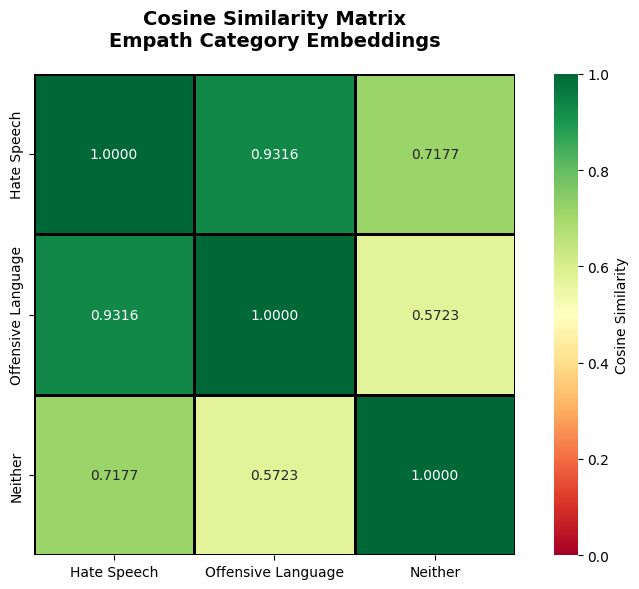

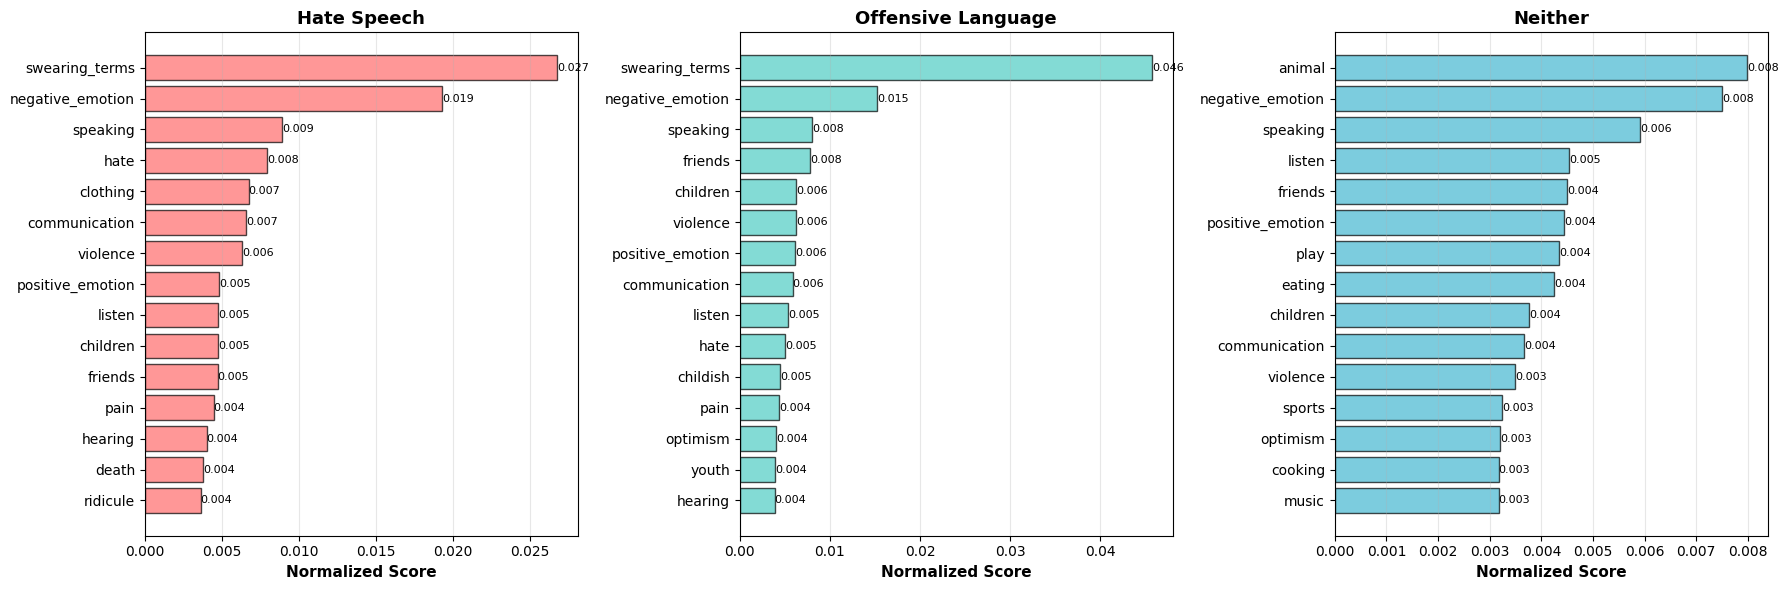

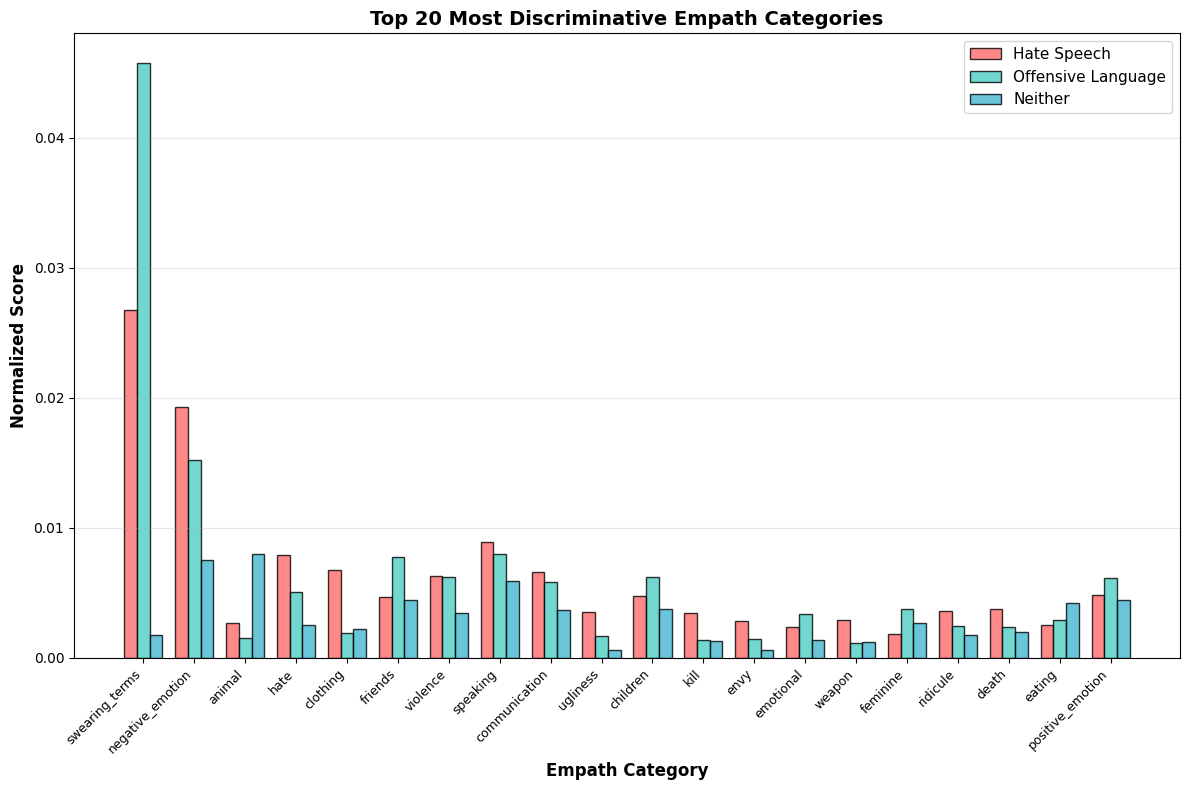

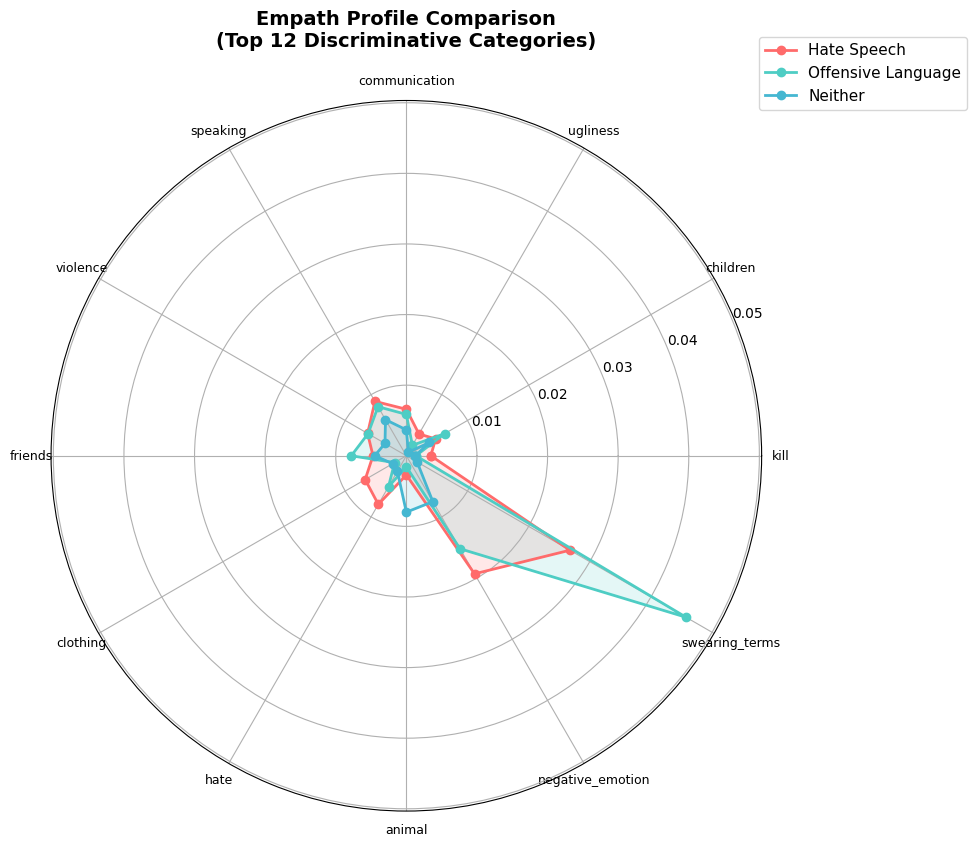

In [67]:
def get_empath_vector(df, category, text_column='tweet'):
    """
    Generate Empath embedding vector for a category.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with text data
    category : str
        Category name
    text_column : str
        Column containing text
        
    Returns:
    --------
    np.array : Normalized Empath feature vector
    dict : Raw Empath scores
    """
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    all_text = ' '.join(category_df[text_column].dropna().astype(str).values)
    
    # Initialize Empath
    lexicon = Empath()
    
    # Analyze text
    empath_scores = lexicon.analyze(all_text, normalize=True)
    
    # Convert to vector (sorted by category name for consistency)
    categories = sorted(empath_scores.keys())
    vector = np.array([empath_scores[cat] for cat in categories])
    
    return vector, empath_scores, categories

def calculate_cosine_similarity_matrix(empath_vectors, categories):
    """
    Calculate pairwise cosine similarity between category vectors.
    
    Returns:
    --------
    pd.DataFrame : Cosine similarity matrix
    """
    # Stack vectors into matrix
    vectors = np.vstack([empath_vectors[cat] for cat in categories])
    
    # Calculate cosine similarity
    cos_sim_matrix = cosine_similarity(vectors)
    
    # Create DataFrame
    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    cos_sim_df = pd.DataFrame(cos_sim_matrix,
                              index=category_labels,
                              columns=category_labels)
    
    return cos_sim_df

def get_top_empath_categories(empath_scores, n=10):
    """Get top N Empath categories by score."""
    sorted_cats = sorted(empath_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_cats[:n]

def create_empath_comparison_table(empath_vectors, categories):
    """Create detailed pairwise comparison table."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Only upper triangle
                vec1 = empath_vectors[cat1]
                vec2 = empath_vectors[cat2]
                
                # Cosine similarity
                cos_sim = cosine_similarity([vec1], [vec2])[0, 0]
                
                # Euclidean distance
                euclidean_dist = np.linalg.norm(vec1 - vec2)
                
                # Manhattan distance
                manhattan_dist = np.sum(np.abs(vec1 - vec2))
                
                results.append({
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Cosine Similarity': cos_sim,
                    'Euclidean Distance': euclidean_dist,
                    'Manhattan Distance': manhattan_dist,
                    'Dissimilarity (%)': (1 - cos_sim) * 100
                })
    
    return pd.DataFrame(results)

def compare_empath_profiles(empath_scores_dict, categories, n_top=15):
    """
    Compare top Empath categories across groups.
    
    Returns:
    --------
    pd.DataFrame : Comparison of top categories
    """
    all_categories = set()
    for scores in empath_scores_dict.values():
        top_cats = [cat for cat, _ in get_top_empath_categories(scores, n_top)]
        all_categories.update(top_cats)
    
    comparison_data = []
    for empath_cat in sorted(all_categories):
        row = {'Empath_Category': empath_cat}
        for cat in categories:
            row[cat.replace('_', ' ').title()] = empath_scores_dict[cat].get(empath_cat, 0)
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by variance (categories that differ most between groups)
    cat_cols = [cat.replace('_', ' ').title() for cat in categories]
    comparison_df['Variance'] = comparison_df[cat_cols].var(axis=1)
    comparison_df = comparison_df.sort_values('Variance', ascending=False)
    
    return comparison_df

def plot_cosine_similarity_heatmap(cos_sim_df):
    """Plot heatmap of cosine similarities."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cos_sim_df, annot=True, fmt='.4f', cmap='RdYlGn',
               cbar_kws={'label': 'Cosine Similarity'},
               square=True, linewidths=1, linecolor='black',
               vmin=0, vmax=1, ax=ax)
    
    ax.set_title("Cosine Similarity Matrix\nEmpath Category Embeddings", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def plot_top_empath_categories(empath_scores_dict, categories, n_top=15):
    """Plot top Empath categories for each group."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        
        top_cats = get_top_empath_categories(empath_scores_dict[cat], n_top)
        cat_names = [cat_name for cat_name, _ in top_cats]
        scores = [score for _, score in top_cats]
        
        bars = ax.barh(range(len(cat_names)), scores, color=color, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(cat_names)))
        ax.set_yticklabels(cat_names, fontsize=10)
        ax.set_xlabel('Normalized Score', fontsize=11, fontweight='bold')
        ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for bar, score in zip(bars, scores):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{score:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_discriminative_categories(comparison_df, n_top=20):
    """Plot most discriminative Empath categories."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get top discriminative categories
    top_discriminative = comparison_df.head(n_top)
    
    cat_cols = [col for col in top_discriminative.columns if col not in ['Empath_Category', 'Variance']]
    
    x = np.arange(len(top_discriminative))
    width = 0.25
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (col, color) in enumerate(zip(cat_cols, colors)):
        offset = (idx - 1) * width
        bars = ax.bar(x + offset, top_discriminative[col], width, 
                     label=col, color=color, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Empath Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {n_top} Most Discriminative Empath Categories', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_discriminative['Empath_Category'], rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plot_vector_comparison(empath_vectors, categories):
    """Plot radar/spider chart comparing category vectors."""
    from math import pi
    
    # Get most discriminative dimensions
    vectors = np.vstack([empath_vectors[cat] for cat in categories])
    variances = np.var(vectors, axis=0)
    top_indices = np.argsort(variances)[-12:]  # Top 12 most varying dimensions
    
    # For visualization, we need category names
    # Get them from the first vector's keys
    lexicon = Empath()
    all_empath_cats = sorted(lexicon.cats.keys())
    selected_cats = [all_empath_cats[i] for i in top_indices]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    angles = [n / len(selected_cats) * 2 * pi for n in range(len(selected_cats))]
    angles += angles[:1]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for cat, color in zip(categories, colors):
        values = [empath_vectors[cat][i] for i in top_indices]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=cat.replace('_', ' ').title(), color=color)
        ax.fill(angles, values, alpha=0.15, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(selected_cats, fontsize=9)
    ax.set_ylim(0, max([max(empath_vectors[cat]) for cat in categories]) * 1.1)
    ax.set_title('Empath Profile Comparison\n(Top 12 Discriminative Categories)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

print("="*80)
print("EMPATH CATEGORIZATION AND COSINE SIMILARITY ANALYSIS")
print("="*80)

print("\nGenerating Empath embeddings...")
empath_vectors = {}
empath_scores_dict = {}
empath_category_names = None

for cat in CATEGORIES:
    print(f"  Processing {cat.replace('_', ' ').title()}...")
    vector, scores, cat_names = get_empath_vector(df, cat, text_column='tweet')
    empath_vectors[cat] = vector
    empath_scores_dict[cat] = scores
    if empath_category_names is None:
        empath_category_names = cat_names

print(f"\n✓ Generated {len(empath_category_names)} Empath features per category")

# Calculate cosine similarity
print("\n" + "="*80)
print("COSINE SIMILARITY MATRIX")
print("="*80)
cos_sim_df = calculate_cosine_similarity_matrix(empath_vectors, CATEGORIES)
print(cos_sim_df.to_string())

# Detailed comparison
print("\n" + "="*80)
print("DETAILED PAIRWISE COMPARISON")
print("="*80)
detailed_table = create_empath_comparison_table(empath_vectors, CATEGORIES)
print(detailed_table.to_string(index=False))

# Top Empath categories per group
print("\n" + "="*80)
print("TOP 10 EMPATH CATEGORIES PER GROUP")
print("="*80)
for cat in CATEGORIES:
    print(f"\n{cat.replace('_', ' ').title()}:")
    top_cats = get_top_empath_categories(empath_scores_dict[cat], 10)
    for i, (empath_cat, score) in enumerate(top_cats, 1):
        print(f"  {i:2d}. {empath_cat:20s}: {score:.4f}")

# Most discriminative Empath categories
print("\n" + "="*80)
print("MOST DISCRIMINATIVE EMPATH CATEGORIES")
print("="*80)
comparison_df = compare_empath_profiles(empath_scores_dict, CATEGORIES, n_top=30)
print("\nTop 20 categories with highest variance across groups:")
print(comparison_df.head(20).to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("DISCRIMINATION POWER ANALYSIS")
print("="*80)

for _, row in detailed_table.iterrows():
    cat1 = row['Category 1']
    cat2 = row['Category 2']
    cos_sim = row['Cosine Similarity']
    dissim = row['Dissimilarity (%)']
    
    print(f"\n{cat1} vs {cat2}:")
    print(f"  Cosine Similarity: {cos_sim:.4f}")
    print(f"  Dissimilarity: {dissim:.2f}%")
    
    if cos_sim > 0.95:
        discrimination = "very low - categories are nearly identical"
    elif cos_sim > 0.90:
        discrimination = "low - categories are very similar"
    elif cos_sim > 0.80:
        discrimination = "moderate - some differences exist"
    elif cos_sim > 0.70:
        discrimination = "good - clear differences"
    else:
        discrimination = "excellent - substantially different"
    
    print(f"  → Discrimination power: {discrimination}")

# Overall discrimination assessment
avg_cos_sim = detailed_table['Cosine Similarity'].mean()
print(f"\nOverall Assessment:")
print(f"  Average cosine similarity: {avg_cos_sim:.4f}")
print(f"  Average dissimilarity: {(1-avg_cos_sim)*100:.2f}%")

if avg_cos_sim > 0.90:
    print("  → Empath has LOW discrimination power - categories are too similar")
elif avg_cos_sim > 0.75:
    print("  → Empath has MODERATE discrimination power")
else:
    print("  → Empath has GOOD discrimination power - can distinguish categories")

# Visualizations
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

plot_cosine_similarity_heatmap(cos_sim_df)
plot_top_empath_categories(empath_scores_dict, CATEGORIES, n_top=15)
plot_discriminative_categories(comparison_df, n_top=20)
plot_vector_comparison(empath_vectors, CATEGORIES)

## Task 9: Word Embeddings and Category Discrimination Analysis

In [68]:
def load_pretrained_doc2vec():
    print("Loading pretrained Word2Vec model (Google News 300d)...")
    word_vectors = api.load('word2vec-google-news-300')
    print("Pretrained model loaded (300-dimension)")
    return word_vectors

def get_doc2vec_embedding_pretrained(text, word_vectors):
    tokens = word_tokenize(str(text).lower())

    vectors = []
    for token in tokens:
        if token in word_vectors:
            vectors.append(word_vectors[token])
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_vectors.vector_size)

def get_doc2vec_category_embedding(df, category, word_vectors):
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)

    print(f"  Computing Doc2Vec embeddings for {len(category_df)} posts...")

    embeddings = []
    for text in tqdm(category_df['tweet'].dropna(), desc=f"  {category}"):
        emb = get_doc2vec_embedding_pretrained(text, word_vectors)
        embeddings.append(emb)
    
    if embeddings:
        category_vector = np.mean(embeddings, axis=0)
    else:
        category_vector = np.zeros(word_vectors.vector_size)

    return category_vector

def load_pretrained_distilbert():
    print("Loading pretrained DistilBERT model...")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModel.from_pretrained("distilbert-base-uncased")
    model.eval()
    print("DistilBERT model loaded (768 dimensions)")
    return tokenizer, model

def get_distilbert_embedding(text, tokenizer, model, max_length=512):
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding=True)

    with torch.no_grad():
        output = model(**inputs)

    # Use mean pooling of last hidden state
    embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()

    return embeddings

def get_distilbert_category_embedding(df, category, tokenizer, model):
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)

    print(f"  Computing DistilBERT embeddings for {len(category_df)} posts...")

    embeddings = []
    for text in tqdm(category_df['tweet'].dropna(), desc=f"    {category}"):
        emb = get_distilbert_embedding(str(text), tokenizer, model)
        embeddings.append(emb)
    
    if embeddings:
        category_vector = np.mean(embeddings, axis=0)
    else:
        category_vector = np.zeros(768)
    return category_vector

# Note: get_empath_vector is already defined in Cell 22
# Reusing that function instead of duplicating it here

# SIMILARITY CALCULATION & ANALYSIS
def calculate_similarity_matrix(embeddings, categories, method_name):
    vectors = np.vstack([embeddings[cat] for cat in categories])
    cos_sim_matrix = cosine_similarity(vectors)

    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    cos_sim_df = pd.DataFrame(cos_sim_matrix, index=category_labels, columns=category_labels)

    return cos_sim_df

def create_comparison_table(embeddings, categories, method_name):
    """Create detailed pairwise comparison."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                vec1 = embeddings[cat1]
                vec2 = embeddings[cat2]
                
                cos_sim = cosine_similarity([vec1], [vec2])[0, 0]
                euclidean = np.linalg.norm(vec1 - vec2)
                
                results.append({
                    'Method': method_name,
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Cosine Similarity': cos_sim,
                    'Euclidean Distance': euclidean,
                    'Dissimilarity (%)': (1 - cos_sim) * 100
                })
    
    return pd.DataFrame(results)

def plot_similarity_comparison(all_similarities, methods):
    """Plot comparison of cosine similarities across methods."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (method, sim_df) in enumerate(zip(methods, all_similarities)):
        ax = axes[idx]
        
        sns.heatmap(sim_df, annot=True, fmt='.4f', cmap='RdYlGn',
                   square=True, linewidths=1, linecolor='black',
                   vmin=0, vmax=1, ax=ax,
                   cbar_kws={'label': 'Cosine Similarity'})
        
        ax.set_title(f'{method}\nCosine Similarity', fontsize=13, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def plot_discrimination_comparison(all_results):
    """Plot bar chart comparing discrimination power."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    methods = all_results['Method'].unique()
    comparisons = []
    for _, row in all_results.iterrows():
        comp = f"{row['Category 1']} vs\n{row['Category 2']}"
        if comp not in comparisons:
            comparisons.append(comp)
    
    x = np.arange(len(methods))
    width = 0.25
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # Plot 1: Cosine Similarity
    for idx, (comp, color) in enumerate(zip(comparisons, colors)):
        data = []
        for method in methods:
            method_data = all_results[all_results['Method'] == method]
            val = method_data.iloc[idx]['Cosine Similarity']
            data.append(val)
        
        offset = (idx - 1) * width
        ax1.bar(x + offset, data, width, label=comp, color=color, alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
    ax1.set_title('Cosine Similarity by Method', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods, fontsize=11)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 1])
    
    # Plot 2: Dissimilarity
    for idx, (comp, color) in enumerate(zip(comparisons, colors)):
        data = []
        for method in methods:
            method_data = all_results[all_results['Method'] == method]
            val = method_data.iloc[idx]['Dissimilarity (%)']
            data.append(val)
        
        offset = (idx - 1) * width
        ax2.bar(x + offset, data, width, label=comp, color=color, alpha=0.8, edgecolor='black')
    
    ax2.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Dissimilarity (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Dissimilarity by Method (Higher = Better)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(methods, fontsize=11)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plot_embedding_pca(all_embeddings, categories, methods):
    from sklearn.decomposition import PCA
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (method, embeddings) in enumerate(zip(methods, all_embeddings)):
        ax = axes[idx]
        
        vectors = np.vstack([embeddings[cat] for cat in categories])
        
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors)
        
        for i, (cat, color) in enumerate(zip(categories, colors)):
            ax.scatter(vectors_2d[i, 0], vectors_2d[i, 1], 
                      s=300, c=color, alpha=0.7, edgecolor='black', linewidth=2,
                      label=cat.replace('_', ' ').title())
            ax.annotate(cat.replace('_', ' ').title(), 
                       (vectors_2d[i, 0], vectors_2d[i, 1]),
                       fontsize=11, fontweight='bold', ha='center')
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', 
                     fontsize=11, fontweight='bold')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', 
                     fontsize=11, fontweight='bold')
        ax.set_title(f'{method}\nPCA Visualization', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("="*80)
print("EMBEDDING-BASED SIMILARITY ANALYSIS")
print("Pretrained Doc2Vec vs Pretrained DistilBERT vs Empath")
print("="*80)

# Note: df should already be loaded and preprocessed from earlier cells
# If running this cell standalone, uncomment the following:
# df = load_and_explore_data('reddit_hate_speech.csv')
# df = preprocess_data(df, stop_words)

# ========================================================================
# 1. PRETRAINED DOC2VEC
# ========================================================================
print("\n" + "="*80)
print("1. PRETRAINED DOC2VEC (Google News Word2Vec 300d)")
print("="*80)

word_vectors = load_pretrained_doc2vec()

doc2vec_embeddings = {}
for cat in CATEGORIES:
    doc2vec_embeddings[cat] = get_doc2vec_category_embedding(df, cat, word_vectors)
    print(f"  {cat.replace('_', ' ').title()}: vector shape {doc2vec_embeddings[cat].shape}")

doc2vec_sim = calculate_similarity_matrix(doc2vec_embeddings, CATEGORIES, 'Doc2Vec')
doc2vec_table = create_comparison_table(doc2vec_embeddings, CATEGORIES, 'Doc2Vec (Pretrained)')

print("\nDoc2Vec Cosine Similarity Matrix:")
print(doc2vec_sim.to_string())

# ========================================================================
# 2. PRETRAINED DISTILBERT
# ========================================================================
print("\n" + "="*80)
print("2. PRETRAINED DISTILBERT (distilbert-base-uncased)")
print("="*80)

tokenizer, bert_model = load_pretrained_distilbert()

distilbert_embeddings = {}
for cat in CATEGORIES:
    distilbert_embeddings[cat] = get_distilbert_category_embedding(
        df, cat, tokenizer, bert_model
    )
    print(f"  {cat.replace('_', ' ').title()}: vector shape {distilbert_embeddings[cat].shape}")

distilbert_sim = calculate_similarity_matrix(distilbert_embeddings, CATEGORIES, 'DistilBERT')
distilbert_table = create_comparison_table(distilbert_embeddings, CATEGORIES, 'DistilBERT (Pretrained)')

print("\nDistilBERT Cosine Similarity Matrix:")
print(distilbert_sim.to_string())

# ========================================================================
# 3. EMPATH
# ========================================================================
print("\n" + "="*80)
print("3. EMPATH EMBEDDINGS")
print("="*80)

empath_embeddings = {}
for cat in CATEGORIES:
    vector, scores, cat_names = get_empath_vector(df, cat, text_column='tweet')
    empath_embeddings[cat] = vector
    print(f"  {cat.replace('_', ' ').title()}: vector shape {empath_embeddings[cat].shape}")

empath_sim = calculate_similarity_matrix(empath_embeddings, CATEGORIES, 'Empath')
empath_table = create_comparison_table(empath_embeddings, CATEGORIES, 'Empath')

print("\nEmpath Cosine Similarity Matrix:")
print(empath_sim.to_string())

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*80)

all_results = pd.concat([doc2vec_table, distilbert_table, empath_table], ignore_index=True)

comparison_summary = []
for i, cat1 in enumerate(CATEGORIES):
    for j, cat2 in enumerate(CATEGORIES):
        if i < j:
            pair = f"{cat1.replace('_', ' ').title()} vs {cat2.replace('_', ' ').title()}"
            
            doc2vec_sim_val = all_results[(all_results['Method']=='Doc2Vec (Pretrained)') & 
                                            (all_results['Category 1']==cat1.replace('_', ' ').title()) &
                                            (all_results['Category 2']==cat2.replace('_', ' ').title())]['Cosine Similarity'].values[0]
            
            distilbert_sim_val = all_results[(all_results['Method']=='DistilBERT (Pretrained)') & 
                                            (all_results['Category 1']==cat1.replace('_', ' ').title()) &
                                            (all_results['Category 2']==cat2.replace('_', ' ').title())]['Cosine Similarity'].values[0]
            
            empath_sim_val = all_results[(all_results['Method']=='Empath') & 
                                        (all_results['Category 1']==cat1.replace('_', ' ').title()) &
                                        (all_results['Category 2']==cat2.replace('_', ' ').title())]['Cosine Similarity'].values[0]
            
            comparison_summary.append({
                'Category Pair': pair,
                'Doc2Vec Similarity': doc2vec_sim_val,
                'Doc2Vec Dissim (%)': (1-doc2vec_sim_val)*100,
                'DistilBERT Similarity': distilbert_sim_val,
                'DistilBERT Dissim (%)': (1-distilbert_sim_val)*100,
                'Empath Similarity': empath_sim_val,
                'Empath Dissim (%)': (1-empath_sim_val)*100
            })

comparison_df = pd.DataFrame(comparison_summary)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)
print("DISCRIMINATION POWER RANKING")
print("="*80)

discrimination_scores = []
for method_name in ['Doc2Vec (Pretrained)', 'DistilBERT (Pretrained)', 'Empath']:
    method_data = all_results[all_results['Method'] == method_name]
    
    avg_dissim = method_data['Dissimilarity (%)'].mean()
    std_dissim = method_data['Dissimilarity (%)'].std()
    min_sim = method_data['Cosine Similarity'].min()
    max_sim = method_data['Cosine Similarity'].max()
    
    discrimination_scores.append({
        'Method': method_name,
        'Avg Similarity': method_data['Cosine Similarity'].mean(),
        'Avg Dissimilarity (%)': avg_dissim,
        'Std Dissimilarity': std_dissim,
        'Min Similarity': min_sim,
        'Max Similarity': max_sim,
        'Discrimination Score': avg_dissim
    })

discrimination_df = pd.DataFrame(discrimination_scores)
discrimination_df = discrimination_df.sort_values('Discrimination Score', ascending=False)
discrimination_df['Rank'] = range(1, len(discrimination_df) + 1)

print(discrimination_df[['Rank', 'Method', 'Avg Similarity', 'Avg Dissimilarity (%)', 
                        'Min Similarity', 'Max Similarity']].to_string(index=False))


EMBEDDING-BASED SIMILARITY ANALYSIS
Pretrained Doc2Vec vs Pretrained DistilBERT vs Empath

1. PRETRAINED DOC2VEC (Google News Word2Vec 300d)
Loading pretrained Word2Vec model (Google News 300d)...
Pretrained model loaded (300-dimension)
  Computing Doc2Vec embeddings for 1430 posts...


  hate_speech: 100%|██████████| 1430/1430 [00:00<00:00, 9290.75it/s]


  Hate Speech: vector shape (300,)
  Computing Doc2Vec embeddings for 19190 posts...


  offensive_language: 100%|██████████| 19190/19190 [00:02<00:00, 8908.31it/s]


  Offensive Language: vector shape (300,)
  Computing Doc2Vec embeddings for 4163 posts...


  neither: 100%|██████████| 4163/4163 [00:00<00:00, 8735.53it/s]


  Neither: vector shape (300,)

Doc2Vec Cosine Similarity Matrix:
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.989057  0.970093
Offensive Language     0.989057            1.000000  0.963119
Neither                0.970093            0.963119  1.000000

2. PRETRAINED DISTILBERT (distilbert-base-uncased)
Loading pretrained DistilBERT model...
DistilBERT model loaded (768 dimensions)
  Computing DistilBERT embeddings for 1430 posts...


    hate_speech: 100%|██████████| 1430/1430 [00:21<00:00, 65.44it/s]


  Hate Speech: vector shape (768,)
  Computing DistilBERT embeddings for 19190 posts...


    offensive_language: 100%|██████████| 19190/19190 [04:48<00:00, 66.55it/s]


  Offensive Language: vector shape (768,)
  Computing DistilBERT embeddings for 4163 posts...


    neither: 100%|██████████| 4163/4163 [01:01<00:00, 67.74it/s]


  Neither: vector shape (768,)

DistilBERT Cosine Similarity Matrix:
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.995659  0.986825
Offensive Language     0.995659            1.000000  0.982332
Neither                0.986825            0.982332  1.000000

3. EMPATH EMBEDDINGS
  Hate Speech: vector shape (194,)
  Offensive Language: vector shape (194,)
  Neither: vector shape (194,)

Empath Cosine Similarity Matrix:
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.931620  0.717716
Offensive Language     0.931620            1.000000  0.572336
Neither                0.717716            0.572336  1.000000

COMPREHENSIVE COMPARISON TABLE
                    Category Pair  Doc2Vec Similarity  Doc2Vec Dissim (%)  DistilBERT Similarity  DistilBERT Dissim (%)  Empath Similarity  Empath Dissim (%)
Hate Speech vs Offensive Language            0.989057            1.094278        

## Task 10: WordNet Token Matching Analysis

In [69]:
spell_autocorrect = Speller(lang='en')

print("Spell checkers initialized (TextBlob + Autocorrect)")

def detect_spelling_errors_textblob(text):
    blob = TextBlob(text)
    errors = []
    
    for word in blob.words:
        if word.isalpha() and not is_valid_word(word):
            corrected = str(TextBlob(word).correct())
            if corrected.lower() != word.lower():
                errors.append(word.lower())
    
    return errors

def detect_spelling_errors_autocorrect(text):
    tokens = word_tokenize(text.lower())
    errors = []
    
    for token in tokens:
        if token.isalpha():
            corrected = spell_autocorrect(token)
            if corrected != token and not is_valid_word(token):
                errors.append(token)
    
    return errors

def analyze_text(text, method='textblob'):
    cleaned = clean_text(text)
    if not cleaned:
        return {
            'total_tokens': 0,
            'spelling_errors': 0,
            'not_in_wordnet': 0,
            'total_errors': 0,
            'error_rate': 0.0,
            'error_words': []
        }
    
    # Tokenize (only alphabetic)
    tokens = [t.lower() for t in word_tokenize(cleaned) if t.isalpha()]
    
    if not tokens:
        return {
            'total_tokens': 0,
            'spelling_errors': 0,
            'not_in_wordnet': 0,
            'total_errors': 0,
            'error_rate': 0.0,
            'error_words': []
        }
    
    # Detect spelling errors based on method
    if method == 'textblob':
        spell_errors = detect_spelling_errors_textblob(cleaned)
    elif method == 'autocorrect':
        spell_errors = detect_spelling_errors_autocorrect(cleaned)
    elif method == 'combined':
        # Use both methods and take union
        errors1 = set(detect_spelling_errors_textblob(cleaned))
        errors2 = set(detect_spelling_errors_autocorrect(cleaned))
        spell_errors = list(errors1.union(errors2))
    else:
        spell_errors = []
    
    # Find words not in WordNet
    not_in_wordnet = [t for t in tokens if not is_valid_word(t)]
    
    # Total unique errors (union of spelling errors and words not in WordNet)
    all_errors = list(set(spell_errors + not_in_wordnet))
    
    error_rate = len(all_errors) / len(tokens) if tokens else 0.0
    
    return {
        'total_tokens': len(tokens),
        'spelling_errors': len(spell_errors),
        'not_in_wordnet': len(not_in_wordnet),
        'total_errors': len(all_errors),
        'error_rate': error_rate,
        'error_words': all_errors
    }

def analyze_category(df, category, text_column='tweet', method='textblob'):
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    print(f"  Analyzing {len(category_df)} posts in {category.replace('_', ' ').title()}...")
    
    # Analyze each post
    results = []
    all_errors = []
    
    for idx, row in category_df.iterrows():
        analysis = analyze_text(row[text_column], method=method)
        analysis['post_id'] = idx
        results.append(analysis)
        all_errors.extend(analysis['error_words'])
    
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    total_posts = len(category_df)
    posts_with_errors = (results_df['total_errors'] > 0).sum()
    total_tokens = results_df['total_tokens'].sum()
    total_spelling_errors = results_df['spelling_errors'].sum()
    total_not_in_wordnet = results_df['not_in_wordnet'].sum()
    total_errors = results_df['total_errors'].sum()
    
    stats = {
        'category': category,
        'total_posts': total_posts,
        'posts_with_errors': posts_with_errors,
        'posts_with_errors_pct': (posts_with_errors / total_posts * 100) if total_posts > 0 else 0,
        'total_tokens': total_tokens,
        'total_spelling_errors': total_spelling_errors,
        'total_not_in_wordnet': total_not_in_wordnet,
        'total_errors': total_errors,
        'overall_error_rate': (total_errors / total_tokens * 100) if total_tokens > 0 else 0,
        'spelling_error_rate': (total_spelling_errors / total_tokens * 100) if total_tokens > 0 else 0,
        'avg_errors_per_post': total_errors / total_posts if total_posts > 0 else 0,
        'top_errors': Counter(all_errors).most_common(20)
    }
    
    return stats, results_df

def analyze_all_categories(df, text_column='tweet', method='textblob'):
    categories = ['hate_speech', 'offensive_language', 'neither']
    all_stats = {}
    all_results = {}
    
    print(f"Analyzing linguistic quality using {method.upper()}...\n")
    
    for cat in categories:
        stats, results_df = analyze_category(df, cat, text_column, method)
        all_stats[cat] = stats
        all_results[cat] = results_df
    
    # Create summary table
    summary_data = []
    for cat in categories:
        summary_data.append({
            'Category': cat.replace('_', ' ').title(),
            'Total Posts': all_stats[cat]['total_posts'],
            'Posts w/ Errors': all_stats[cat]['posts_with_errors'],
            'Posts w/ Errors (%)': all_stats[cat]['posts_with_errors_pct'],
            'Total Tokens': all_stats[cat]['total_tokens'],
            'Spelling Errors': all_stats[cat]['total_spelling_errors'],
            'Not in WordNet': all_stats[cat]['total_not_in_wordnet'],
            'Total Errors': all_stats[cat]['total_errors'],
            'Error Rate (%)': all_stats[cat]['overall_error_rate'],
            'Spelling Error Rate (%)': all_stats[cat]['spelling_error_rate'],
            'Avg Errors/Post': all_stats[cat]['avg_errors_per_post']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Error Rate (%)')
    summary_df['Quality Rank'] = range(1, len(summary_df) + 1)
    
    print("\n✓ Analysis complete!\n")
    
    return all_stats, all_results, summary_df


def plot_error_comparison(summary_df):
    """Plot error comparison across categories."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    plot_df = summary_df.sort_values('Quality Rank')
    categories = plot_df['Category'].values
    
    # Plot 1: Posts with Errors (%)
    ax = axes[0, 0]
    bars = ax.bar(categories, plot_df['Posts w/ Errors (%)'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    ax.set_title('Posts with Errors', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
               ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Error Types
    ax = axes[0, 1]
    x = np.arange(len(categories))
    width = 0.35
    bars1 = ax.bar(x - width/2, plot_df['Spelling Errors'], width, 
                   label='Spelling Errors', color='#FF6B6B', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, plot_df['Not in WordNet'], width,
                   label='Not in WordNet', color='#4ECDC4', alpha=0.7, edgecolor='black')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_title('Error Type Breakdown', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Error Rates
    ax = axes[1, 0]
    bars = ax.bar(categories, plot_df['Error Rate (%)'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Error Rate (%)', fontsize=11, fontweight='bold')
    ax.set_title('Overall Error Rate', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%',
               ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Avg Errors per Post
    ax = axes[1, 1]
    bars = ax.bar(categories, plot_df['Avg Errors/Post'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Avg Errors', fontsize=11, fontweight='bold')
    ax.set_title('Avg Errors per Post', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}',
               ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_top_error_words(all_stats, n_words=15):
    """Plot top error words for each category."""
    categories = ['hate_speech', 'offensive_language', 'neither']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        top_errors = all_stats[cat]['top_errors'][:n_words]
        words = [w for w, _ in top_errors]
        counts = [c for _, c in top_errors]
        
        bars = ax.barh(range(len(words)), counts, color=color, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=9)
        ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title(f'Top {n_words} Error Words\n{cat.replace("_", " ").title()}',
                    fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        
        for bar, count in zip(bars, counts):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, f' {count}',
                   ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_error_distribution(all_results):
    """Plot distribution of error rates."""
    categories = ['hate_speech', 'offensive_language', 'neither']
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        results_df = all_results[cat]
        error_rates = results_df['error_rate'] * 100
        
        ax.hist(error_rates, bins=20, color=color, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Error Rate (%)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Number of Posts', fontsize=11, fontweight='bold')
        ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        mean_error = error_rates.mean()
        median_error = error_rates.median()
        ax.axvline(mean_error, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_error:.1f}%')
        ax.axvline(median_error, color='blue', linestyle='--', linewidth=2,
                  label=f'Median: {median_error:.1f}%')
        ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# COMPARISON FUNCTION
# ============================================================================

def compare_spell_checkers(df, text_column='tweet'):
    methods = ['textblob', 'autocorrect', 'combined']
    comparison_results = []
    
    print("Comparing spell checking methods...\n")
    
    for method in methods:
        print(f"Testing {method.upper()}...")
        _, _, summary_df = analyze_all_categories(df, text_column, method=method)
        
        for _, row in summary_df.iterrows():
            comparison_results.append({
                'Method': method.upper(),
                'Category': row['Category'],
                'Error Rate (%)': row['Error Rate (%)'],
                'Spelling Error Rate (%)': row['Spelling Error Rate (%)'],
                'Posts w/ Errors (%)': row['Posts w/ Errors (%)']
            })
    
    comparison_df = pd.DataFrame(comparison_results)
    
    print("\n✓ Comparison complete!\n")
    
    return comparison_df

def plot_method_comparison(comparison_df):
    """Plot comparison of different spell checking methods."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    categories = comparison_df['Category'].unique()
    methods = comparison_df['Method'].unique()
    x = np.arange(len(categories))
    width = 0.25
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    metrics = ['Error Rate (%)', 'Spelling Error Rate (%)', 'Posts w/ Errors (%)']
    titles = ['Overall Error Rate', 'Spelling Error Rate', 'Posts with Errors']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]
        
        for i, (method, color) in enumerate(zip(methods, colors)):
            data = comparison_df[comparison_df['Method'] == method][metric].values
            offset = (i - 1) * width
            ax.bar(x + offset, data, width, label=method, color=color, alpha=0.7, edgecolor='black')
        
        ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(categories, fontsize=9)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


# Note: df should already be loaded and preprocessed from earlier cells
# The stopwords were already downloaded as 'stop_words' in earlier cells
# If running this cell standalone, uncomment the following:
# stop_words_set = set(stopwords.words('english'))
# df = load_and_explore_data('reddit_hate_speech.csv')
# df = preprocess_data(df, stop_words_set)

all_stats, all_results, summary_df = analyze_all_categories(df, method='textblob')

# Display results
print("="*80)
print("LINGUISTIC QUALITY SUMMARY (TextBlob)")
print("="*80)
print(summary_df.to_string(index=False))

plot_error_comparison(summary_df)
plot_top_error_words(all_stats)
plot_error_distribution(all_results)

comparison_df = compare_spell_checkers(df)

print("\n" + "="*80)
print("METHOD COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

plot_method_comparison(comparison_df)

all_stats_ac, all_results_ac, summary_ac = analyze_all_categories(df, method='autocorrect')
all_stats_combined, all_results_combined, summary_combined = analyze_all_categories(df, method='combined')

Spell checkers initialized (TextBlob + Autocorrect)
Analyzing linguistic quality using TEXTBLOB...

  Analyzing 1430 posts in Hate Speech...
  Analyzing 19190 posts in Offensive Language...


KeyboardInterrupt: 

## Task 11: Edit Distance and Spell Correction

In [ ]:
spell = SpellChecker()

print(" PySpellChecker initialized")

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def is_valid_word(word):
    word_lower = word.lower()
    if word.isdigit():
        return True
    if len(wordnet.synsets(word_lower)) > 0:
        return True
    if word_lower in spell:
        return True
    return False


def analyze_spelling_errors(text):
    cleaned = clean_text(text)
    if not cleaned:
        return []
    
    tokens = [t.lower() for t in word_tokenize(cleaned) if t.isalpha()]
    
    errors = []
    for token in tokens:
        if not is_valid_word(token):
            # Get correction from pyspellchecker
            correction = spell.correction(token)
            
            if correction and correction != token:
                # Calculate edit distance
                edit_dist = levenshtein_distance(token, correction)
                
                errors.append({
                    'original': token,
                    'correction': correction,
                    'edit_distance': edit_dist
                })
    
    return errors

def analyze_category_errors(df, category, text_column='tweet'):
    """
    Analyze all spelling errors in a category.
    """
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    print(f"  Analyzing {len(category_df)} posts in {category.replace('_', ' ').title()}...")
    
    # Collect all errors
    all_errors = []
    edit_distance_counts = defaultdict(int)
    
    for idx, row in category_df.iterrows():
        errors = analyze_spelling_errors(row[text_column])
        all_errors.extend(errors)
        
        for error in errors:
            edit_distance_counts[error['edit_distance']] += 1
    
    # Create DataFrame
    errors_df = pd.DataFrame(all_errors)
    
    if len(errors_df) == 0:
        return {
            'category': category,
            'total_errors': 0,
            'edit_distance_distribution': {},
            'edit_distance_proportions': {},
            'mean_edit_distance': 0,
            'median_edit_distance': 0
        }, errors_df
    
    # Calculate proportions
    total_errors = len(errors_df)
    edit_distance_proportions = {
        dist: (count / total_errors * 100) 
        for dist, count in edit_distance_counts.items()
    }
    
    # Statistics
    stats = {
        'category': category,
        'total_errors': total_errors,
        'edit_distance_distribution': dict(edit_distance_counts),
        'edit_distance_proportions': edit_distance_proportions,
        'mean_edit_distance': errors_df['edit_distance'].mean(),
        'median_edit_distance': errors_df['edit_distance'].median(),
        'most_common_errors': Counter([e['original'] for e in all_errors]).most_common(20)
    }
    
    return stats, errors_df

def analyze_all_categories(df, text_column='tweet'):
    categories = ['hate_speech', 'offensive_language', 'neither']
    all_stats = {}
    all_errors_df = {}
    
    print("Analyzing spelling correction costs (edit distances)...\n")
    
    for cat in categories:
        stats, errors_df = analyze_category_errors(df, cat, text_column)
        all_stats[cat] = stats
        all_errors_df[cat] = errors_df
    
    summary_data = []
    for cat in categories:
        summary_data.append({
            'Category': cat.replace('_', ' ').title(),
            'Total Errors': all_stats[cat]['total_errors'],
            'Mean Edit Distance': all_stats[cat]['mean_edit_distance'],
            'Median Edit Distance': all_stats[cat]['median_edit_distance'],
            'Edit Dist 1 (%)': all_stats[cat]['edit_distance_proportions'].get(1, 0),
            'Edit Dist 2 (%)': all_stats[cat]['edit_distance_proportions'].get(2, 0),
            'Edit Dist 3 (%)': all_stats[cat]['edit_distance_proportions'].get(3, 0),
            'Edit Dist 4+ (%)': sum([v for k, v in all_stats[cat]['edit_distance_proportions'].items() if k >= 4])
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n✓ Analysis complete!\n")
    
    return all_stats, all_errors_df, summary_df

def plot_edit_distance_distribution(all_stats):
    categories = ['hate_speech', 'offensive_language', 'neither']
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        
        # Get edit distance distribution
        dist_dict = all_stats[cat]['edit_distance_proportions']
        
        if not dist_dict:
            ax.text(0.5, 0.5, 'No errors found', ha='center', va='center', fontsize=12)
            ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
            continue
        
        # Sort by edit distance
        distances = sorted(dist_dict.keys())
        proportions = [dist_dict[d] for d in distances]
        
        bars = ax.bar(distances, proportions, color=color, alpha=0.7, edgecolor='black', width=0.6)
        ax.set_xlabel('Edit Distance', fontsize=11, fontweight='bold')
        ax.set_ylabel('Proportion (%)', fontsize=11, fontweight='bold')
        ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax.set_xticks(distances)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, prop in zip(bars, proportions):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{prop:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Add mean line
        mean_dist = all_stats[cat]['mean_edit_distance']
        ax.axvline(mean_dist, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_dist:.2f}')
        ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_edit_distance_comparison(summary_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    categories = summary_df['Category'].values
    x = np.arange(len(categories))
    width = 0.2
    colors = ['#FF6B6B', '#FFA07A', '#FFD700', '#98FB98']
    
    # Plot 1: Stacked bar chart
    edit_1 = summary_df['Edit Dist 1 (%)'].values
    edit_2 = summary_df['Edit Dist 2 (%)'].values
    edit_3 = summary_df['Edit Dist 3 (%)'].values
    edit_4plus = summary_df['Edit Dist 4+ (%)'].values
    
    ax1.bar(categories, edit_1, label='Edit Distance 1', color=colors[0], alpha=0.8, edgecolor='black')
    ax1.bar(categories, edit_2, bottom=edit_1, label='Edit Distance 2', 
           color=colors[1], alpha=0.8, edgecolor='black')
    ax1.bar(categories, edit_3, bottom=edit_1+edit_2, label='Edit Distance 3',
           color=colors[2], alpha=0.8, edgecolor='black')
    ax1.bar(categories, edit_4plus, bottom=edit_1+edit_2+edit_3, label='Edit Distance 4+',
           color=colors[3], alpha=0.8, edgecolor='black')
    
    ax1.set_ylabel('Proportion (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Edit Distance Distribution (Stacked)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Grouped bar chart for mean/median
    mean_dist = summary_df['Mean Edit Distance'].values
    median_dist = summary_df['Median Edit Distance'].values
    
    bars1 = ax2.bar(x - width/2, mean_dist, width, label='Mean', 
                    color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x + width/2, median_dist, width, label='Median',
                    color='#4ECDC4', alpha=0.8, edgecolor='black')
    
    ax2.set_xlabel('Category', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Edit Distance', fontsize=12, fontweight='bold')
    ax2.set_title('Mean vs Median Edit Distance', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_error_examples(all_stats, n_examples=10):
    """Plot most common spelling errors for each category."""
    categories = ['hate_speech', 'offensive_language', 'neither']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        
        top_errors = all_stats[cat]['most_common_errors'][:n_examples]
        if not top_errors:
            ax.text(0.5, 0.5, 'No errors found', ha='center', va='center', fontsize=12)
            ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
            continue
        
        words = [w for w, _ in top_errors]
        counts = [c for _, c in top_errors]
        
        bars = ax.barh(range(len(words)), counts, color=color, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=9)
        ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title(f'Top {n_examples} Misspelled Words\n{cat.replace("_", " ").title()}',
                    fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        
        for bar, count in zip(bars, counts):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, f' {count}',
                   ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_box_comparison(all_errors_df):
    """Box plot comparison of edit distances across categories."""
    categories = ['hate_speech', 'offensive_language', 'neither']
    
    # Prepare data for box plot
    data_for_plot = []
    labels_for_plot = []
    
    for cat in categories:
        if len(all_errors_df[cat]) > 0:
            data_for_plot.append(all_errors_df[cat]['edit_distance'].values)
            labels_for_plot.append(cat.replace('_', ' ').title())
    
    if not data_for_plot:
        print("No errors found for box plot")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True,
                    notch=True, showmeans=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(marker='D', markerfacecolor='green', markersize=8))
    
    ax.set_ylabel('Edit Distance', fontsize=12, fontweight='bold')
    ax.set_title('Edit Distance Distribution (Box Plot)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Color boxes differently
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.tight_layout()
    plt.show()

# DISCRIMINATION ANALYSIS

def analyze_discrimination_power(summary_df, all_stats):
    """
    Analyze discrimination power based on edit distance patterns.
    """
    print("\n" + "="*80)
    print("DISCRIMINATION POWER ANALYSIS")
    print("="*80)
    
    discrimination_data = []
    
    for _, row in summary_df.iterrows():
        cat = row['Category']
        
        # Simple errors (edit distance 1) are easier to correct
        simple_errors = row['Edit Dist 1 (%)']
        
        # Complex errors (edit distance 2+) are harder to correct
        complex_errors = 100 - simple_errors
        
        # Mean edit distance indicates overall error severity
        mean_dist = row['Mean Edit Distance']
        
        discrimination_data.append({
            'Category': cat,
            'Simple Errors (%)': simple_errors,
            'Complex Errors (%)': complex_errors,
            'Mean Edit Distance': mean_dist,
            'Discrimination Score': complex_errors * mean_dist  # Higher = more discriminative
        })
    
    discrim_df = pd.DataFrame(discrimination_data)
    discrim_df = discrim_df.sort_values('Discrimination Score', ascending=False)
    discrim_df['Rank'] = range(1, len(discrim_df) + 1)
    
    return discrim_df

def print_interpretation(summary_df, discrim_df):
    """Print detailed interpretation of results."""
    print("\n" + "="*80)
    print("INTERPRETATION")
    print("="*80)
    
    for _, row in summary_df.iterrows():
        cat = row['Category']
        mean_dist = row['Mean Edit Distance']
        edit1_pct = row['Edit Dist 1 (%)']
        
        print(f"\n{cat}:")
        print(f"  Total spelling errors: {row['Total Errors']:,}")
        print(f"  Mean edit distance: {mean_dist:.2f}")
        print(f"  Median edit distance: {row['Median Edit Distance']:.2f}")
        
        # Error severity assessment
        if mean_dist < 1.5:
            severity = "LOW - mostly simple typos"
        elif mean_dist < 2.0:
            severity = "MODERATE - mix of simple and complex errors"
        elif mean_dist < 2.5:
            severity = "HIGH - many complex errors"
        else:
            severity = "VERY HIGH - severe spelling issues"
        
        print(f"  Error severity: {severity}")
        print(f"  Simple errors (dist=1): {edit1_pct:.1f}%")
        print(f"  Complex errors (dist≥2): {100-edit1_pct:.1f}%")
    
    print("\n" + "="*80)
    print("DISCRIMINATION POWER RANKING")
    print("="*80)
    print(discrim_df[['Rank', 'Category', 'Mean Edit Distance', 
                     'Simple Errors (%)', 'Complex Errors (%)']].to_string(index=False))
    
    print("\n" + "="*80)
    print("CONCLUSION")
    print("="*80)
    
    # Compare categories
    high_quality = summary_df.iloc[summary_df['Mean Edit Distance'].idxmin()]['Category']
    low_quality = summary_df.iloc[summary_df['Mean Edit Distance'].idxmax()]['Category']
    
    print(f"\nBest spelling quality: {high_quality}")
    print(f"Worst spelling quality: {low_quality}")
    
    mean_range = summary_df['Mean Edit Distance'].max() - summary_df['Mean Edit Distance'].min()
    
    if mean_range > 0.5:
        print(f"\n→ SIGNIFICANT difference in spelling error complexity (Δ={mean_range:.2f})")
        print("→ Edit distance patterns can DISCRIMINATE between categories")
    elif mean_range > 0.2:
        print(f"\n→ MODERATE difference in spelling error complexity (Δ={mean_range:.2f})")
        print("→ Edit distance patterns show SOME discrimination power")
    else:
        print(f"\n→ SMALL difference in spelling error complexity (Δ={mean_range:.2f})")
        print("→ Edit distance patterns have LIMITED discrimination power")


# Note: df should already be loaded and preprocessed from earlier cells
# If running this cell standalone, uncomment the following:
# df = load_and_explore_data('reddit_hate_speech.csv')

all_stats, all_errors_df, summary_df = analyze_all_categories(df)

print("="*80)
print("EDIT DISTANCE ANALYSIS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

discrim_df = analyze_discrimination_power(summary_df, all_stats)

print_interpretation(summary_df, discrim_df)

plot_edit_distance_distribution(all_stats)
plot_edit_distance_comparison(summary_df)
plot_box_comparison(all_errors_df)
plot_error_examples(all_stats, n_examples=10)

hate_speech_errors = all_errors_df['hate_speech']
print(f"\nHate Speech - Sample errors:")
print(hate_speech_errors.head(10))